In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# 1. Load the CSV file and explicitly convert 'Time' to datetime with seconds
df = pd.read_csv('ALL_imputed.csv')
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')

# 2. Check for missing values and handle them (forward-fill if any)
print("Missing values in each column:\n", df.isnull().sum())
df.fillna(method='ffill', inplace=True)

# 3. Add cyclical time features to capture temporal patterns
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['DayOfWeek'] = df['Time'].dt.dayofweek

# Encode time features cyclically using sine and cosine transformations
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# 4. Prepare price data and scale it
price_columns = ['Last_WTI', 'Last_BRENT', 'Last_GAS']
prices = df[price_columns].values
price_scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = price_scaler.fit_transform(prices)

# 5. Prepare all features (scaled prices + time features)
time_features = df[['Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos', 
                   'DayOfWeek_sin', 'DayOfWeek_cos']].values
features = np.hstack((prices_scaled, time_features))

# 6. Function to create sequences for RNN, including time
def create_sequences(features, targets, times, window_size):
    X, y, y_times = [], [], []
    for i in range(len(features) - window_size):
        X.append(features[i:i + window_size])           # Sequence of past window_size steps
        y.append(targets[i + window_size])             # Next time step's prices
        y_times.append(times[i + window_size])         # Corresponding datetime
    return np.array(X), np.array(y), np.array(y_times)

# Set window size (e.g., 12 steps = 1 hour of 5-minute data)
window_size = 12
X, y, y_times = create_sequences(features, prices_scaled, df['Time'].values, window_size)

# 7. Split data into training and testing sets (chronologically, no shuffling)
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
y_times_train, y_times_test = y_times[:split_index], y_times[split_index:]

# 8. Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(window_size, 9)))  # 9 features
model.add(Dense(3))  # Output 3 prices (WTI, BRENT, GAS)
model.compile(optimizer='adam', loss='mse')

# 9. Train the model
history = model.fit(X_train, y_train, epochs=3, batch_size=32, 
                    validation_data=(X_test, y_test), verbose=1)

# 10. Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# 11. Make predictions on the test set
y_pred_scaled = model.predict(X_test)
y_pred = price_scaler.inverse_transform(y_pred_scaled)  # Inverse transform to actual prices
y_test_actual = price_scaler.inverse_transform(y_test)

# 12. Evaluate the model for each energy future and print with datetime
results_df = pd.DataFrame({
    'Time': y_times_test,
    'Actual_WTI': y_test_actual[:, 0],
    'Predicted_WTI': y_pred[:, 0],
    'Actual_BRENT': y_test_actual[:, 1],
    'Predicted_BRENT': y_pred[:, 1],
    'Actual_GAS': y_test_actual[:, 2],
    'Predicted_GAS': y_pred[:, 2]
})
print("Sample of predictions with datetime:\n", results_df.head())

for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    mae = mean_absolute_error(y_test_actual[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred[:, i]))
    print(f'{name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}')

# 13. Plot actual vs predicted prices with datetime on x-axis
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    plt.figure(figsize=(15, 5))
    plt.plot(results_df['Time'], results_df[f'Actual_{name}'], label=f'Actual {name} Price', color='blue')
    plt.plot(results_df['Time'], results_df[f'Predicted_{name}'], label=f'Predicted {name} Price', color='orange', linestyle='--')
    plt.title(f'{name} Price Prediction')
    plt.xlabel('DateTime')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 1. Load and preprocess data
df = pd.read_csv('ALL_imputed.csv')
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')
df.fillna(method='ffill', inplace=True)

# 2. Add multi-scale features
df['WTI_1h_mean'] = df['Last_WTI'].rolling(window=12).mean()
df['WTI_1d_mean'] = df['Last_WTI'].rolling(window=288).mean()
df['BRENT_1h_mean'] = df['Last_BRENT'].rolling(window=12).mean()
df['GAS_1h_mean'] = df['Last_GAS'].rolling(window=12).mean()
df.fillna(method='bfill', inplace=True)

# 3. Cyclical time features
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['DayOfWeek'] = df['Time'].dt.dayofweek
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# 4. Prepare and scale price data
price_columns = ['Last_WTI', 'Last_BRENT', 'Last_GAS', 'WTI_1h_mean', 'WTI_1d_mean', 'BRENT_1h_mean', 'GAS_1h_mean']
prices = df[price_columns].values
price_scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = price_scaler.fit_transform(prices)

# 5. Combine features
time_features = df[['Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos', 'DayOfWeek_sin', 'DayOfWeek_cos']].values
features = np.hstack((prices_scaled, time_features))  # 13 features

# 6. Create sequences
def create_sequences(features, targets, times, window_size):
    X, y, y_times = [], [], []
    for i in range(len(features) - window_size):
        X.append(features[i:i + window_size])
        y.append(targets[i + window_size, :3])  # Predict only the 3 main prices
        y_times.append(times[i + window_size])
    return np.array(X), np.array(y), np.array(y_times)

window_size = 24  # 2 hours
X, y, y_times = create_sequences(features, prices_scaled, df['Time'].values, window_size)

# 7. Split data
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
y_times_test = y_times[split_index:]

# 8. Define improved LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(window_size, 13)))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3))
model.compile(optimizer='adam', loss='mse')

# 9. Train with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                    validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# 10. Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# 11. Predict and evaluate
y_pred_scaled = model.predict(X_test)
y_pred = price_scaler.inverse_transform(np.hstack((y_pred_scaled, np.zeros((y_pred_scaled.shape[0], 4)))))[:, :3]
y_test_actual = price_scaler.inverse_transform(np.hstack((y_test, np.zeros((y_test.shape[0], 4)))))[:, :3]

results_df = pd.DataFrame({
    'Time': y_times_test,
    'Actual_WTI': y_test_actual[:, 0], 'Predicted_WTI': y_pred[:, 0],
    'Actual_BRENT': y_test_actual[:, 1], 'Predicted_BRENT': y_pred[:, 1],
    'Actual_GAS': y_test_actual[:, 2], 'Predicted_GAS': y_pred[:, 2]
})
print("Sample of predictions:\n", results_df.head())

for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    mae = mean_absolute_error(y_test_actual[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred[:, i]))
    print(f'{name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}')

# 12. Plot with datetime
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    plt.figure(figsize=(15, 5))
    plt.plot(results_df['Time'], results_df[f'Actual_{name}'], label=f'Actual {name} Price', color='blue')
    plt.plot(results_df['Time'], results_df[f'Predicted_{name}'], label=f'Predicted {name} Price', color='orange', linestyle='--')
    plt.title(f'{name} Price Prediction')
    plt.xlabel('DateTime')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# 1. Load the CSV file and explicitly convert 'Time' to datetime with seconds
df = pd.read_csv('ALL_imputed.csv')
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')

# 2. Check for missing values and handle them (forward-fill if any)
print("Missing values in each column:\n", df.isnull().sum())
df.fillna(method='ffill', inplace=True)

# 3. Add cyclical time features to capture temporal patterns
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['DayOfWeek'] = df['Time'].dt.dayofweek

# Encode time features cyclically using sine and cosine transformations
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# 4. Define all feature columns (7 WTI, 7 Brent, 7 Gasoline)
feature_columns = ['Open_WTI', 'High_WTI', 'Low_WTI', 'Last_WTI', 'Change_WTI', '%Chg_WTI', 'Volume_WTI', 'Open_BRENT', 'High_BRENT', 'Low_BRENT', 'Last_BRENT', 'Change_BRENT', '%Chg_BRENT', 'Volume_BRENT', 'Open_GAS', 'High_GAS', 'Low_GAS', 'Last_GAS', 'Change_GAS', '%Chg_GAS', 'Volume_GAS']

# 5. Preprocess percentage values in feature columns
def convert_percentage_to_float(value):
    if isinstance(value, str) and '%' in value:
        return float(value.replace('%', '')) / 100
    return value

# Apply conversion to all feature columns
for col in feature_columns:
    df[col] = df[col].apply(convert_percentage_to_float)

# Ensure all feature columns are numeric
df[feature_columns] = df[feature_columns].astype(float)

# Prepare price data and scale it
prices = df[feature_columns].values
price_scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = price_scaler.fit_transform(prices)

# 5. Prepare all features (scaled prices + time features)
time_features = df[['Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos', 
                   'DayOfWeek_sin', 'DayOfWeek_cos']].values
features = np.hstack((prices_scaled, time_features))

# 6. Prepare target variables (Last_WTI, Last_BRENT, Last_GAS) and scale them
target_columns = ['Last_WTI', 'Last_BRENT', 'Last_GAS']
targets = df[target_columns].values
target_scaler = MinMaxScaler(feature_range=(0, 1))
targets_scaled = target_scaler.fit_transform(targets)

# 7. Function to create sequences for RNN, including time
def create_sequences(features, targets, times, window_size):
    X, y, y_times = [], [], []
    for i in range(len(features) - window_size):
        X.append(features[i:i + window_size])           # Sequence of past window_size steps
        y.append(targets[i + window_size])             # Next time step's prices
        y_times.append(times[i + window_size])         # Corresponding datetime
    return np.array(X), np.array(y), np.array(y_times)

# Set window size (e.g., 12 steps = 1 hour of 5-minute data)
window_size = 12
X, y, y_times = create_sequences(features, targets_scaled, df['Time'].values, window_size)

# 8. Split data into training and testing sets (chronologically, no shuffling)
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
y_times_train, y_times_test = y_times[:split_index], y_times[split_index:]

# 9. Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(window_size, 27)))  # 27 features (21 price + 6 time)
model.add(Dense(3))  # Output 3 prices (WTI, BRENT, GAS)
model.compile(optimizer='adam', loss='mse')

# 10. Train the model
history = model.fit(X_train, y_train, epochs=3, batch_size=32, 
                    validation_data=(X_test, y_test), verbose=1)

# 11. Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.savefig('training_loss.png')
plt.close()

# 12. Make predictions on the test set
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)  # Inverse transform to actual prices
y_test_actual = target_scaler.inverse_transform(y_test)

# 13. Evaluate the model for each energy future and print with datetime
results_df = pd.DataFrame({
    'Time': y_times_test,
    'Actual_WTI': y_test_actual[:, 0],
    'Predicted_WTI': y_pred[:, 0],
    'Actual_BRENT': y_test_actual[:, 1],
    'Predicted_BRENT': y_pred[:, 1],
    'Actual_GAS': y_test_actual[:, 2],
    'Predicted_GAS': y_pred[:, 2]
})
print("Sample of predictions with datetime:\n", results_df.head())

for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    mae = mean_absolute_error(y_test_actual[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred[:, i]))
    print(f'{name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}')

# 14. Plot actual vs predicted prices with datetime on x-axis
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    plt.figure(figsize=(15, 5))
    plt.plot(results_df['Time'], results_df[f'Actual_{name}'], label=f'Actual {name} Price', color='blue')
    plt.plot(results_df['Time'], results_df[f'Predicted_{name}'], label=f'Predicted {name} Price', color='orange', linestyle='--')
    plt.title(f'{name} Price Prediction')
    plt.xlabel('DateTime')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{name}_price_prediction.png')
    plt.close()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from statsmodels.tsa.api import VAR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# 1. Load the CSV file and explicitly convert 'Time' to datetime with seconds
df = pd.read_csv('ALL_imputed.csv')
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')

# 2. Check for missing values and handle them (forward-fill if any)
print("Missing values in each column:\n", df.isnull().sum())
df.fillna(method='ffill', inplace=True)

# 3. Add cyclical time features to capture temporal patterns
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['DayOfWeek'] = df['Time'].dt.dayofweek

# Encode time features cyclically using sine and cosine transformations
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# 4. Define all feature columns (7 WTI, 7 Brent, 7 Gasoline)
feature_columns = [
    'Open_WTI', 'High_WTI', 'Low_WTI', 'Last_WTI', 'Change_WTI', '%Chg_WTI', 'Volume_WTI',
    'Open_BRENT', 'High_BRENT', 'Low_BRENT', 'Last_BRENT', 'Change_BRENT', '%Chg_BRENT', 'Volume_BRENT',
    'Open_GAS', 'High_GAS', 'Low_GAS', 'Last_GAS', 'Change_GAS', '%Chg_GAS', 'Volume_GAS'
]

# 5. Preprocess percentage values in feature columns
def convert_percentage_to_float(value):
    if isinstance(value, str) and '%' in value:
        return float(value.replace('%', '')) / 100
    return value

# Apply conversion to all feature columns
for col in feature_columns:
    df[col] = df[col].apply(convert_percentage_to_float)

# Ensure all feature columns are numeric
df[feature_columns] = df[feature_columns].astype(float)

# Prepare price data and scale it
prices = df[feature_columns].values
price_scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = price_scaler.fit_transform(prices)

# 6. Prepare all features (scaled prices + time features)
time_features = df[['Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos', 
                   'DayOfWeek_sin', 'DayOfWeek_cos']].values
features = np.hstack((prices_scaled, time_features))

# 7. Prepare target variables (Last_WTI, Last_BRENT, Last_GAS) and scale them
target_columns = ['Last_WTI', 'Last_BRENT', 'Last_GAS']
targets = df[target_columns].values
target_scaler = MinMaxScaler(feature_range=(0, 1))
targets_scaled = target_scaler.fit_transform(targets)

# 8. Function to create sequences for RNN, including time
def create_sequences(features, targets, times, window_size):
    X, y, y_times = [], [], []
    for i in range(len(features) - window_size):
        X.append(features[i:i + window_size])           # Sequence of past window_size steps
        y.append(targets[i + window_size])             # Next time step's prices
        y_times.append(times[i + window_size])         # Corresponding datetime
    return np.array(X), np.array(y), np.array(y_times)

# Set window size (e.g., 12 steps = 1 hour of 5-minute data)
window_size = 12
X, y, y_times = create_sequences(features, targets_scaled, df['Time'].values, window_size)

# 9. Split data into training and testing sets (chronologically, no shuffling)
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
y_times_train, y_times_test = y_times[:split_index], y_times[split_index:]  # Corrected split

# 10. Define and train the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(window_size, 27)))  # 27 features (21 price + 6 time)
model.add(Dense(3))  # Output 3 prices (WTI, BRENT, GAS)
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=3, batch_size=32, 
                    validation_data=(X_test, y_test), verbose=1)

# 11. Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('RNN Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.savefig('rnn_training_loss.png')
plt.close()

# 12. Make RNN predictions on the test set
y_pred_scaled_rnn = model.predict(X_test)
y_pred_rnn = target_scaler.inverse_transform(y_pred_scaled_rnn)  # Inverse transform to actual prices
y_test_actual = target_scaler.inverse_transform(y_test)

# 13. FAVAR Implementation
# Step 1: Extract latent factors using PCA
pca = PCA(n_components=5)  # Extract 5 factors
factors = pca.fit_transform(prices_scaled)  # Use scaled prices for factor extraction

# Step 2: Add quadratic terms for non-linearity
factors_quadratic = np.hstack([factors, factors**2])  # Include original and squared factors

# Step 3: Combine factors with target variables for VAR
var_data = np.hstack([factors_quadratic, targets])  # Combine factors and targets
var_df = pd.DataFrame(var_data, columns=[f'Factor_{i}' for i in range(factors_quadratic.shape[1])] + target_columns)

# Step 4: Split VAR data to align with RNN test set
var_train = var_df.iloc[:split_index]
var_test = var_df.iloc[split_index:split_index + len(X_test)]

# Step 5: Fit VAR model
var_model = VAR(var_train)
var_results = var_model.fit(maxlags=12)  # Use same lag as RNN window_size

# Step 6: Forecast with VAR
forecast_steps = len(var_test)
y_pred_favar = var_results.forecast(var_train.values[-12:], steps=forecast_steps)
y_pred_favar = y_pred_favar[:, -3:]  # Extract predictions for Last_WTI, Last_BRENT, Last_GAS

# Step 7: Align FAVAR predictions with test set (inverse transform if needed)
# Since VAR uses original scale, no inverse transform needed for targets
y_pred_favar = y_pred_favar  # Already in original scale

# 14. Evaluate and compare both models
results_df = pd.DataFrame({
    'Time': y_times_test,
    'Actual_WTI': y_test_actual[:, 0],
    'RNN_Predicted_WTI': y_pred_rnn[:, 0],
    'FAVAR_Predicted_WTI': y_pred_favar[:, 0],
    'Actual_BRENT': y_test_actual[:, 1],
    'RNN_Predicted_BRENT': y_pred_rnn[:, 1],
    'FAVAR_Predicted_BRENT': y_pred_favar[:, 1],
    'Actual_GAS': y_test_actual[:, 2],
    'RNN_Predicted_GAS': y_pred_rnn[:, 2],
    'FAVAR_Predicted_GAS': y_pred_favar[:, 2]
})
print("Sample of predictions with datetime:\n", results_df.head())

# Compute and print MAE and RMSE for both models
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    # RNN metrics
    mae_rnn = mean_absolute_error(y_test_actual[:, i], y_pred_rnn[:, i])
    rmse_rnn = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred_rnn[:, i]))
    # FAVAR metrics
    mae_favar = mean_absolute_error(y_test_actual[:, i], y_pred_favar[:, i])
    rmse_favar = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred_favar[:, i]))
    print(f'{name} - RNN MAE: {mae_rnn:.4f}, RNN RMSE: {rmse_rnn:.4f}')
    print(f'{name} - FAVAR MAE: {mae_favar:.4f}, FAVAR RMSE: {rmse_favar:.4f}')

# 15. Plot actual vs predicted prices for RNN and FAVAR with datetime on x-axis
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    plt.figure(figsize=(15, 5))
    plt.plot(results_df['Time'], results_df[f'Actual_{name}'], label=f'Actual {name} Price', color='blue')
    plt.plot(results_df['Time'], results_df[f'RNN_Predicted_{name}'], label=f'RNN Predicted {name} Price', color='orange', linestyle='--')
    plt.plot(results_df['Time'], results_df[f'FAVAR_Predicted_{name}'], label=f'FAVAR Predicted {name} Price', color='green', linestyle='-.')
    plt.title(f'{name} Price Prediction (RNN vs FAVAR)')
    plt.xlabel('DateTime')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{name}_price_prediction_rnn_favar.png')
    plt.close()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from statsmodels.tsa.api import VAR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# 1. Load the CSV file and explicitly convert 'Time' to datetime with seconds
df = pd.read_csv('ALL_imputed.csv')
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')

# 2. Check for missing values and handle them (forward-fill if any)
print("Missing values in each column:\n", df.isnull().sum())
df.fillna(method='ffill', inplace=True)

# 3. Add cyclical time features to capture temporal patterns
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['DayOfWeek'] = df['Time'].dt.dayofweek

# Encode time features cyclically using sine and cosine transformations
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# 4. Define all feature columns (7 WTI, 7 Brent, 7 Gasoline)
feature_columns = [
    'Open_WTI', 'High_WTI', 'Low_WTI', 'Last_WTI', 'Change_WTI', '%Chg_WTI', 'Volume_WTI',
    'Open_BRENT', 'High_BRENT', 'Low_BRENT', 'Last_BRENT', 'Change_BRENT', '%Chg_BRENT', 'Volume_BRENT',
    'Open_GAS', 'High_GAS', 'Low_GAS', 'Last_GAS', 'Change_GAS', '%Chg_GAS', 'Volume_GAS'
]

# 5. Preprocess percentage values in feature columns
def convert_percentage_to_float(value):
    if isinstance(value, str) and '%' in value:
        return float(value.replace('%', '')) / 100
    return value

# Apply conversion to all feature columns
for col in feature_columns:
    df[col] = df[col].apply(convert_percentage_to_float)

# Ensure all feature columns are numeric
df[feature_columns] = df[feature_columns].astype(float)

# Prepare price data and scale it
prices = df[feature_columns].values
price_scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = price_scaler.fit_transform(prices)

# 6. Prepare all features (scaled prices + time features)
time_features = df[['Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos', 
                   'DayOfWeek_sin', 'DayOfWeek_cos']].values
features = np.hstack((prices_scaled, time_features))

# 7. Prepare target variables (Last_WTI, Last_BRENT, Last_GAS) and scale them
target_columns = ['Last_WTI', 'Last_BRENT', 'Last_GAS']
targets = df[target_columns].values
target_scaler = MinMaxScaler(feature_range=(0, 1))
targets_scaled = target_scaler.fit_transform(targets)

# 8. Function to create sequences for RNN, including time
def create_sequences(features, targets, times, window_size):
    X, y, y_times = [], [], []
    for i in range(len(features) - window_size):
        X.append(features[i:i + window_size])           # Sequence of past window_size steps
        y.append(targets[i + window_size])             # Next time step's prices
        y_times.append(times[i + window_size])         # Corresponding datetime
    return np.array(X), np.array(y), np.array(y_times)

# Set window size for both RNN and FAVAR (e.g., 12 steps = 1 hour of 5-minute data)
window_size = 12
X, y, y_times = create_sequences(features, targets_scaled, df['Time'].values, window_size)

# 9. Split data into training and testing sets (chronologically, no shuffling)
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
y_times_train, y_times_test = y_times[:split_index], y_times[split_index:]  # Align with train and test sets

# 10. Define and train the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(window_size, 27)))  # 27 features (21 price + 6 time)
model.add(Dense(3))  # Output 3 prices (WTI, BRENT, GAS)
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=3, batch_size=32, 
                    validation_data=(X_test, y_test), verbose=1)

# 11. Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('RNN Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.savefig('rnn_training_loss.png')
plt.close()

# 12. Make RNN predictions on the test set
y_pred_scaled_rnn = model.predict(X_test)
y_pred_rnn = target_scaler.inverse_transform(y_pred_scaled_rnn)  # Inverse transform to actual prices
y_test_actual = target_scaler.inverse_transform(y_test)

# 13. FAVAR Implementation with Rolling Windows (same window size as RNN)
favar_window_size = window_size  # Align with RNN window_size (12)

# Initialize arrays to store FAVAR predictions
y_pred_favar = []

# Rolling window loop
for i in range(len(X_test)):
    # Define window indices
    start_idx = split_index + i - favar_window_size
    end_idx = split_index + i
    if start_idx < 0:  # Skip if not enough data for window
        y_pred_favar.append(np.zeros(3))  # Placeholder for skipped predictions
        continue

    # Extract data for the current window
    window_prices = prices_scaled[start_idx:end_idx]
    window_targets = targets[start_idx:end_idx]

    # Standardize window_prices to improve PCA stability
    window_prices_std = (window_prices - window_prices.mean(axis=0)) / window_prices.std(axis=0)
    window_prices_std = np.nan_to_num(window_prices_std, nan=0.0, posinf=0.0, neginf=0.0)  # Handle NaNs/infs

    # Step 1: Extract latent factors using PCA
    pca = PCA(n_components=2)  # Reduced to 2 factors due to small window
    try:
        factors = pca.fit_transform(window_prices_std)
    except Exception as e:
        print(f"PCA failed at step {i}: {e}")
        y_pred_favar.append(np.zeros(3))  # Placeholder for failed PCA
        continue

    # Step 2: Use original factors only (no quadratic terms due to small window)
    factors = factors  # Simplified to avoid overfitting

    # Step 3: Combine factors with target variables for VAR
    var_data = np.hstack([factors, window_targets])
    var_df = pd.DataFrame(var_data, columns=[f'Factor_{j}' for j in range(factors.shape[1])] + target_columns)

    # Step 4: Remove constant columns (zero variance)
    var_df = var_df.loc[:, var_df.std() > 0]  # Keep only columns with non-zero variance
    if var_df.shape[1] < 2:  # Skip if too few columns remain
        print(f"Too few non-constant columns at step {i}")
        y_pred_favar.append(np.zeros(3))  # Placeholder for insufficient data
        continue

    # Step 5: Fit VAR model
    try:
        var_model = VAR(var_df)
        var_results = var_model.fit(maxlags=1, ic=None)  # Reduced lags due to small window
        # Step 6: Forecast one step ahead
        forecast = var_results.forecast(var_df.values[-1:], steps=1)
        # Ensure forecast aligns with target_columns
        forecast_targets = np.zeros(3)  # Placeholder for all targets
        for j, col in enumerate(target_columns):
            if col in var_df.columns:
                col_idx = var_df.columns.get_loc(col)
                forecast_targets[j] = forecast[0, col_idx]
            else:
                forecast_targets[j] = 0.0  # Placeholder if target was constant
        y_pred_favar.append(forecast_targets)  # Predictions for Last_WTI, Last_BRENT, Last_GAS
    except Exception as e:
        print(f"VAR fitting failed at step {i}: {e}")
        y_pred_favar.append(np.zeros(3))  # Placeholder for failed predictions

# Convert FAVAR predictions to array
y_pred_favar = np.array(y_pred_favar)

# 14. Evaluate and compare both models
results_df = pd.DataFrame({
    'Time': y_times_test,
    'Actual_WTI': y_test_actual[:, 0],
    'RNN_Predicted_WTI': y_pred_rnn[:, 0],
    'FAVAR_Predicted_WTI': y_pred_favar[:, 0],
    'Actual_BRENT': y_test_actual[:, 1],
    'RNN_Predicted_BRENT': y_pred_rnn[:, 1],
    'FAVAR_Predicted_BRENT': y_pred_favar[:, 1],
    'Actual_GAS': y_test_actual[:, 2],
    'RNN_Predicted_GAS': y_pred_rnn[:, 2],
    'FAVAR_Predicted_GAS': y_pred_favar[:, 2]
})

# Handle potential NaNs or zeros in FAVAR predictions
valid_mask = ~np.any(y_pred_favar == 0, axis=1)  # Exclude placeholder predictions
results_df_valid = results_df[valid_mask]
print("Sample of predictions with datetime (valid FAVAR predictions):\n", results_df_valid.head())

# Compute and print MAE and RMSE for both models (using valid predictions)
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    # RNN metrics
    mae_rnn = mean_absolute_error(y_test_actual[:, i], y_pred_rnn[:, i])
    rmse_rnn = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred_rnn[:, i]))
    # FAVAR metrics (using valid predictions)
    mae_favar = mean_absolute_error(y_test_actual[valid_mask, i], y_pred_favar[valid_mask, i])
    rmse_favar = np.sqrt(mean_squared_error(y_test_actual[valid_mask, i], y_pred_favar[valid_mask, i]))
    print(f'{name} - RNN MAE: {mae_rnn:.4f}, RNN RMSE: {rmse_rnn:.4f}')
    print(f'{name} - FAVAR MAE: {mae_favar:.4f}, FAVAR RMSE: {rmse_favar:.4f}')

# 15. Plot actual vs predicted prices for RNN and FAVAR with datetime on x-axis
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    plt.figure(figsize=(15, 5))
    plt.plot(results_df['Time'], results_df[f'Actual_{name}'], label=f'Actual {name} Price', color='blue')
    plt.plot(results_df['Time'], results_df[f'RNN_Predicted_{name}'], label=f'RNN Predicted {name} Price', color='orange', linestyle='--')
    plt.plot(results_df['Time'][valid_mask], results_df_valid[f'FAVAR_Predicted_{name}'], label=f'FAVAR Predicted {name} Price', color='green', linestyle='-.')
    plt.title(f'{name} Price Prediction (RNN vs FAVAR, Same Window Size)')
    plt.xlabel('DateTime')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{name}_price_prediction_rnn_favar_same_window.png')
    plt.close()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from statsmodels.tsa.api import VAR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# 1. Load the CSV file and explicitly convert 'Time' to datetime with seconds
df = pd.read_csv('ALL_imputed.csv')
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')

# 3. Add cyclical time features to capture temporal patterns
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['DayOfWeek'] = df['Time'].dt.dayofweek

# Encode time features cyclically using sine and cosine transformations
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# 4. Define all feature columns (7 WTI, 7 Brent, 7 Gasoline)
feature_columns = [
    'Open_WTI', 'High_WTI', 'Low_WTI', 'Last_WTI', 'Change_WTI', '%Chg_WTI', 'Volume_WTI',
    'Open_BRENT', 'High_BRENT', 'Low_BRENT', 'Last_BRENT', 'Change_BRENT', '%Chg_BRENT', 'Volume_BRENT',
    'Open_GAS', 'High_GAS', 'Low_GAS', 'Last_GAS', 'Change_GAS', '%Chg_GAS', 'Volume_GAS'
]

# 5. Preprocess percentage values in feature columns
def convert_percentage_to_float(value):
    if isinstance(value, str) and '%' in value:
        return float(value.replace('%', '')) / 100
    return value

# Apply conversion to all feature columns
for col in feature_columns:
    df[col] = df[col].apply(convert_percentage_to_float)

# Ensure all feature columns are numeric
df[feature_columns] = df[feature_columns].astype(float)

# Prepare price data and scale it
prices = df[feature_columns].values
price_scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = price_scaler.fit_transform(prices)

# 6. Prepare all features (scaled prices + time features)
time_features = df[['Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos', 
                   'DayOfWeek_sin', 'DayOfWeek_cos']].values
features = np.hstack((prices_scaled, time_features))

# 7. Prepare target variables (Last_WTI, Last_BRENT, Last_GAS) and scale them
target_columns = ['Last_WTI', 'Last_BRENT', 'Last_GAS']
targets = df[target_columns].values
target_scaler = MinMaxScaler(feature_range=(0, 1))
targets_scaled = target_scaler.fit_transform(targets)

# 8. Function to create sequences for RNN, including time
def create_sequences(features, targets, times, window_size):
    X, y, y_times = [], [], []
    for i in range(len(features) - window_size):
        X.append(features[i:i + window_size])           # Sequence of past window_size steps
        y.append(targets[i + window_size])             # Next time step's prices
        y_times.append(times[i + window_size])         # Corresponding datetime
    return np.array(X), np.array(y), np.array(y_times)

# Set window size for RNN (e.g., 12 steps = 1 hour of 5-minute data)
window_size = 12
X, y, y_times = create_sequences(features, targets_scaled, df['Time'].values, window_size)

# 9. Split data into training and testing sets (chronologically, no shuffling)
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
y_times_train, y_times_test = y_times[:split_index], y_times[split_index:]  # Align with train and test sets

# 10. Define and train the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(window_size, 27)))  # 27 features (21 price + 6 time)
model.add(Dense(3))  # Output 3 prices (WTI, BRENT, GAS)
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=3, batch_size=32, 
                    validation_data=(X_test, y_test), verbose=1)

# 11. Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('RNN Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.savefig('rnn_training_loss.png')
plt.close()

# 12. Make RNN predictions on the test set
y_pred_scaled_rnn = model.predict(X_test)
y_pred_rnn = target_scaler.inverse_transform(y_pred_scaled_rnn)  # Inverse transform to actual prices
y_test_actual = target_scaler.inverse_transform(y_test)

# 13. FAVAR Implementation with Rolling Windows
# Define rolling window size for FAVAR (e.g., 1000 observations)
favar_window_size = 1000

# Initialize arrays to store FAVAR predictions
y_pred_favar = []

# Rolling window loop
for i in range(len(X_test)):
    # Define window indices
    start_idx = split_index + i - favar_window_size
    end_idx = split_index + i
    if start_idx < 0:  # Skip if not enough data for window
        y_pred_favar.append(np.zeros(3))  # Placeholder for skipped predictions
        continue

    # Extract data for the current window
    window_prices = prices_scaled[start_idx:end_idx]
    window_targets = targets[start_idx:end_idx]

    # Step 1: Extract latent factors using PCA
    pca = PCA(n_components=5)  # Extract 5 factors
    factors = pca.fit_transform(window_prices)

    # Step 2: Add quadratic terms for non-linearity
    factors_quadratic = np.hstack([factors, factors**2])

    # Step 3: Combine factors with target variables for VAR
    var_data = np.hstack([factors_quadratic, window_targets])
    var_df = pd.DataFrame(var_data, columns=[f'Factor_{j}' for j in range(factors_quadratic.shape[1])] + target_columns)

    # Step 4: Fit VAR model
    try:
        var_model = VAR(var_df)
        var_results = var_model.fit(maxlags=12, ic=None)  # Use same lag as RNN window_size
        # Step 5: Forecast one step ahead
        forecast = var_results.forecast(var_df.values[-12:], steps=1)
        y_pred_favar.append(forecast[0, -3:])  # Extract predictions for Last_WTI, Last_BRENT, Last_GAS
    except Exception as e:
        print(f"VAR fitting failed at step {i}: {e}")
        y_pred_favar.append(np.zeros(3))  # Placeholder for failed predictions

# Convert FAVAR predictions to array
y_pred_favar = np.array(y_pred_favar)

# 14. Evaluate and compare both models
results_df = pd.DataFrame({
    'Time': y_times_test,
    'Actual_WTI': y_test_actual[:, 0],
    'RNN_Predicted_WTI': y_pred_rnn[:, 0],
    'FAVAR_Predicted_WTI': y_pred_favar[:, 0],
    'Actual_BRENT': y_test_actual[:, 1],
    'RNN_Predicted_BRENT': y_pred_rnn[:, 1],
    'FAVAR_Predicted_BRENT': y_pred_favar[:, 1],
    'Actual_GAS': y_test_actual[:, 2],
    'RNN_Predicted_GAS': y_pred_rnn[:, 2],
    'FAVAR_Predicted_GAS': y_pred_favar[:, 2]
})

# Handle potential NaNs or zeros in FAVAR predictions
valid_mask = ~np.any(y_pred_favar == 0, axis=1)  # Exclude placeholder predictions
results_df_valid = results_df[valid_mask]
print("Sample of predictions with datetime (valid FAVAR predictions):\n", results_df_valid.head())

# Compute and print MAE and RMSE for both models (using valid predictions)
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    # RNN metrics
    mae_rnn = mean_absolute_error(y_test_actual[:, i], y_pred_rnn[:, i])
    rmse_rnn = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred_rnn[:, i]))
    # FAVAR metrics (using valid predictions)
    mae_favar = mean_absolute_error(y_test_actual[valid_mask, i], y_pred_favar[valid_mask, i])
    rmse_favar = np.sqrt(mean_squared_error(y_test_actual[valid_mask, i], y_pred_favar[valid_mask, i]))
    print(f'{name} - RNN MAE: {mae_rnn:.4f}, RNN RMSE: {rmse_rnn:.4f}')
    print(f'{name} - FAVAR MAE: {mae_favar:.4f}, FAVAR RMSE: {rmse_favar:.4f}')

# 15. Plot actual vs predicted prices for RNN and FAVAR with datetime on x-axis
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    plt.figure(figsize=(15, 5))
    plt.plot(results_df['Time'], results_df[f'Actual_{name}'], label=f'Actual {name} Price', color='blue')
    plt.plot(results_df['Time'], results_df[f'RNN_Predicted_{name}'], label=f'RNN Predicted {name} Price', color='orange', linestyle='--')
    plt.plot(results_df['Time'][valid_mask], results_df_valid[f'FAVAR_Predicted_{name}'], label=f'FAVAR Predicted {name} Price', color='green', linestyle='-.')
    plt.title(f'{name} Price Prediction (RNN vs Rolling Window FAVAR)')
    plt.xlabel('DateTime')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{name}_price_prediction_rnn_favar_rolling.png')
    plt.close()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from statsmodels.tsa.api import VAR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# 1. Load the CSV file and explicitly convert 'Time' to datetime with seconds
df = pd.read_csv('ALL_imputed.csv')
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')

# 2. Check for missing values and handle them (forward-fill if any)
print("Missing values in each column:\n", df.isnull().sum())
df.fillna(method='ffill', inplace=True)

# 3. Add cyclical time features to capture temporal patterns
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['DayOfWeek'] = df['Time'].dt.dayofweek

# Encode time features cyclically using sine and cosine transformations
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# 4. Define all feature columns (7 WTI, 7 Brent, 7 Gasoline)
feature_columns = [
    'Open_WTI', 'High_WTI', 'Low_WTI', 'Last_WTI', 'Change_WTI', '%Chg_WTI', 'Volume_WTI',
    'Open_BRENT', 'High_BRENT', 'Low_BRENT', 'Last_BRENT', 'Change_BRENT', '%Chg_BRENT', 'Volume_BRENT',
    'Open_GAS', 'High_GAS', 'Low_GAS', 'Last_GAS', 'Change_GAS', '%Chg_GAS', 'Volume_GAS'
]

# 5. Preprocess percentage values in feature columns
def convert_percentage_to_float(value):
    if isinstance(value, str) and '%' in value:
        return float(value.replace('%', '')) / 100
    return value

# Apply conversion to all feature columns
for col in feature_columns:
    df[col] = df[col].apply(convert_percentage_to_float)

# Ensure all feature columns are numeric
df[feature_columns] = df[feature_columns].astype(float)

# Prepare price data and scale it
prices = df[feature_columns].values
price_scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = price_scaler.fit_transform(prices)

# 6. Prepare all features (scaled prices + time features)
time_features = df[['Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos', 
                   'DayOfWeek_sin', 'DayOfWeek_cos']].values
features = np.hstack((prices_scaled, time_features))

# 7. Prepare target variables (Last_WTI, Last_BRENT, Last_GAS) and scale them
target_columns = ['Last_WTI', 'Last_BRENT', 'Last_GAS']
targets = df[target_columns].values
target_scaler = MinMaxScaler(feature_range=(0, 1))
targets_scaled = target_scaler.fit_transform(targets)

# 8. Function to create sequences for RNN, including time
def create_sequences(features, targets, times, window_size):
    X, y, y_times = [], [], []
    for i in range(len(features) - window_size):
        X.append(features[i:i + window_size])           # Sequence of past window_size steps
        y.append(targets[i + window_size])             # Next time step's prices
        y_times.append(times[i + window_size])         # Corresponding datetime
    return np.array(X), np.array(y), np.array(y_times)

# Set window size for RNN (e.g., 12 steps = 1 hour of 5-minute data)
window_size = 12
X, y, y_times = create_sequences(features, targets_scaled, df['Time'].values, window_size)

# 9. Split data into training and testing sets (chronologically, no shuffling)
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
y_times_train, y_times_test = y_times[:split_index], y_times[split_index:]  # Align with train and test sets

# 10. Define and train the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(window_size, 27)))  # 27 features (21 price + 6 time)
model.add(Dense(3))  # Output 3 prices (WTI, BRENT, GAS)
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=3, batch_size=32, 
                    validation_data=(X_test, y_test), verbose=1)

# 11. Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('RNN Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.savefig('rnn_training_loss.png')
plt.close()

# 12. Make RNN predictions on the test set
y_pred_scaled_rnn = model.predict(X_test)
y_pred_rnn = target_scaler.inverse_transform(y_pred_scaled_rnn)  # Inverse transform to actual prices
y_test_actual = target_scaler.inverse_transform(y_test)

# 13. FAVAR Implementation with Rolling Windows
favar_window_size = 500  # Optimized window for balance of stability and speed

# Fit PCA once on training data
pca = PCA(n_components=3)  # Reduced to 3 components for speed
pca.fit(prices_scaled[:split_index])

# Initialize arrays to store FAVAR predictions
y_pred_favar = []

# Rolling window loop
for i in range(len(X_test)):
    # Define window indices
    start_idx = split_index + i - favar_window_size
    end_idx = split_index + i
    if start_idx < 0:  # Skip if not enough data for window
        y_pred_favar.append(np.zeros(3))  # Placeholder for skipped predictions
        continue

    # Extract data for the current window
    window_prices = prices_scaled[start_idx:end_idx]
    window_targets = targets[start_idx:end_idx]

    # Standardize window_prices to improve PCA stability
    window_prices_std = (window_prices - window_prices.mean(axis=0)) / window_prices.std(axis=0)
    window_prices_std = np.nan_to_num(window_prices_std, nan=0.0, posinf=0.0, neginf=0.0)  # Handle NaNs/infs

    # Step 1: Apply pre-fitted PCA
    try:
        factors = pca.transform(window_prices_std)
    except Exception as e:
        print(f"PCA transform failed at step {i}: {e}")
        y_pred_favar.append(np.zeros(3))  # Placeholder for failed PCA
        continue

    # Step 2: Add quadratic terms for non-linearity
    factors_quadratic = np.hstack([factors, factors**2])

    # Step 3: Combine factors with target variables for VAR
    var_data = np.hstack([factors_quadratic, window_targets])
    var_df = pd.DataFrame(var_data, columns=[f'Factor_{j}' for j in range(factors_quadratic.shape[1])] + target_columns)

    # Step 4: Remove constant columns (zero variance)
    var_df = var_df.loc[:, var_df.std() > 0]  # Keep only columns with non-zero variance
    if var_df.shape[1] < 2:  # Skip if too few columns remain
        print(f"Too few non-constant columns at step {i}")
        y_pred_favar.append(np.zeros(3))  # Placeholder for insufficient data
        continue

    # Step 5: Fit VAR model
    try:
        var_model = VAR(var_df)
        var_results = var_model.fit(maxlags=6, ic=None)  # Reduced lags for speed
        # Step 6: Forecast one step ahead
        forecast = var_results.forecast(var_df.values[-6:], steps=1)
        # Ensure forecast aligns with target_columns
        forecast_targets = np.zeros(3)  # Placeholder for all targets
        for j, col in enumerate(target_columns):
            if col in var_df.columns:
                col_idx = var_df.columns.get_loc(col)
                forecast_targets[j] = forecast[0, col_idx]
            else:
                forecast_targets[j] = 0.0  # Placeholder if target was constant
        y_pred_favar.append(forecast_targets)  # Predictions for Last_WTI, Last_BRENT, Last_GAS
    except Exception as e:
        print(f"VAR fitting failed at step {i}: {e}")
        y_pred_favar.append(np.zeros(3))  # Placeholder for failed predictions

# Convert FAVAR predictions to array
y_pred_favar = np.array(y_pred_favar)

# 14. Evaluate and compare both models
results_df = pd.DataFrame({
    'Time': y_times_test,
    'Actual_WTI': y_test_actual[:, 0],
    'RNN_Predicted_WTI': y_pred_rnn[:, 0],
    'FAVAR_Predicted_WTI': y_pred_favar[:, 0],
    'Actual_BRENT': y_test_actual[:, 1],
    'RNN_Predicted_BRENT': y_pred_rnn[:, 1],
    'FAVAR_Predicted_BRENT': y_pred_favar[:, 1],
    'Actual_GAS': y_test_actual[:, 2],
    'RNN_Predicted_GAS': y_pred_rnn[:, 2],
    'FAVAR_Predicted_GAS': y_pred_favar[:, 2]
})

# Handle potential NaNs or zeros in FAVAR predictions
valid_mask = ~np.any(y_pred_favar == 0, axis=1)  # Exclude placeholder predictions
results_df_valid = results_df[valid_mask]
print("Sample of predictions with datetime (valid FAVAR predictions):\n", results_df_valid.head())

# Compute and print MAE and RMSE for both models (using valid predictions)
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    # RNN metrics
    mae_rnn = mean_absolute_error(y_test_actual[:, i], y_pred_rnn[:, i])
    rmse_rnn = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred_rnn[:, i]))
    # FAVAR metrics (using valid predictions)
    mae_favar = mean_absolute_error(y_test_actual[valid_mask, i], y_pred_favar[valid_mask, i])
    rmse_favar = np.sqrt(mean_squared_error(y_test_actual[valid_mask, i], y_pred_favar[valid_mask, i]))
    print(f'{name} - RNN MAE: {mae_rnn:.4f}, RNN RMSE: {rmse_rnn:.4f}')
    print(f'{name} - FAVAR MAE: {mae_favar:.4f}, FAVAR RMSE: {rmse_favar:.4f}')

# 15. Plot actual vs predicted prices for RNN and FAVAR with datetime on x-axis
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    plt.figure(figsize=(15, 5))
    plt.plot(results_df['Time'], results_df[f'Actual_{name}'], label=f'Actual {name} Price', color='blue')
    plt.plot(results_df['Time'], results_df[f'RNN_Predicted_{name}'], label=f'RNN Predicted {name} Price', color='orange', linestyle='--')
    plt.plot(results_df['Time'][valid_mask], results_df_valid[f'FAVAR_Predicted_{name}'], label=f'FAVAR Predicted {name} Price', color='green', linestyle='-.')
    plt.title(f'{name} Price Prediction (RNN vs Rolling Window FAVAR)')
    plt.xlabel('DateTime')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{name}_price_prediction_rnn_favar_rolling.png')
    plt.close()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank
from statsmodels.tsa.vector_ar.var_model import VAR
import matplotlib.pyplot as plt

# 1. Load the CSV file and explicitly convert 'Time' to datetime with seconds
df = pd.read_csv('ALL_imputed.csv')
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')

# 2. Add cyclical time features to capture temporal patterns
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['DayOfWeek'] = df['Time'].dt.dayofweek

# Encode time features cyclically using sine and cosine transformations
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# 3. Define all feature columns
feature_columns = ['Open_WTI', 'High_WTI', 'Low_WTI', 'Last_WTI', 'Change_WTI', '%Chg_WTI', 'Volume_WTI',
                   'Open_BRENT', 'High_BRENT', 'Low_BRENT', 'Last_BRENT', 'Change_BRENT', '%Chg_BRENT', 'Volume_BRENT',
                   'Open_GAS', 'High_GAS', 'Low_GAS', 'Last_GAS', 'Change_GAS', '%Chg_GAS', 'Volume_GAS']

# 4. Preprocess percentage values in feature columns
def convert_percentage_to_float(value):
    if isinstance(value, str) and '%' in value:
        return float(value.replace('%', '')) / 100
    return value

# Apply conversion to all feature columns
for col in feature_columns:
    df[col] = df[col].apply(convert_percentage_to_float)

# Ensure all feature columns are numeric
df[feature_columns] = df[feature_columns].astype(float)

# 5. Extract the three series for VECM
data = df[['Last_WTI', 'Last_BRENT', 'Last_GAS']]

# 6. Split into train and test
split_index = int(len(data) * 0.8)
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

# 7. Determine cointegration rank
rank_test = select_coint_rank(train_data, det_order=0, k_ar_diff=1, method='trace', signif=0.05)
r = rank_test.rank
print(f"Cointegration rank: {r}")

# Check if cointegration exists
if r == 0:
    print("No cointegration detected. Consider using VAR on differenced data.")
    # For simplicity, proceed with VECM assuming r=1
    r = 1

# 8. Determine lag order
diff_train = train_data.diff().dropna()
var_model = VAR(diff_train)
lag_order = var_model.select_order(maxlags=10)
best_lag = lag_order.aic
print(f"Selected lag order: {best_lag}")

# 9. Set window_size for rolling estimation
window_size = min(1000, split_index)  # Adjust as necessary

# 10. Initialize predictions
predictions = []
prediction_times = []

for t in range(split_index, len(data)):
    if t - window_size < 0:
        continue
    window_data = data.iloc[t - window_size : t]
    model = VECM(window_data, k_ar_diff=best_lag, coint_rank=r)
    result = model.fit()
    forecast = result.predict(steps=1)
    predictions.append(forecast[0])
    prediction_times.append(df['Time'].iloc[t])

# 11. Convert to array
y_pred = np.array(predictions)
y_test_actual = test_data.iloc[:len(predictions)].values

# 12. Create results DataFrame
results_df = pd.DataFrame({
    'Time': prediction_times,
    'Actual_WTI': y_test_actual[:, 0],
    'Predicted_WTI': y_pred[:, 0],
    'Actual_BRENT': y_test_actual[:, 1],
    'Predicted_BRENT': y_pred[:, 1],
    'Actual_GAS': y_test_actual[:, 2],
    'Predicted_GAS': y_pred[:, 2]
})
print("Sample of predictions with datetime:\n", results_df.head())

# 13. Compute metrics
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    mae = mean_absolute_error(y_test_actual[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred[:, i]))
    print(f'{name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}')

# 14. Plot actual vs predicted prices
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    plt.figure(figsize=(15, 5))
    plt.plot(results_df['Time'], results_df[f'Actual_{name}'], label=f'Actual {name} Price', color='blue')
    plt.plot(results_df['Time'], results_df[f'Predicted_{name}'], label=f'Predicted {name} Price', color='orange', linestyle='--')
    plt.title(f'{name} Price Prediction')
    plt.xlabel('DateTime')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{name}_price_prediction_veccm.png')
    plt.close()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# 1. Load the CSV file and explicitly convert 'Time' to datetime with seconds
df = pd.read_csv('ALL_imputed.csv')
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')

# 3. Add cyclical time features to capture temporal patterns
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['DayOfWeek'] = df['Time'].dt.dayofweek

# Encode time features cyclically using sine and cosine transformations
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# 4. Define all feature columns (7 WTI, 7 Brent, 7 Gasoline)
feature_columns = [
    'Open_WTI', 'High_WTI', 'Low_WTI', 'Last_WTI', 'Change_WTI', '%Chg_WTI', 'Volume_WTI',
    'Open_BRENT', 'High_BRENT', 'Low_BRENT', 'Last_BRENT', 'Change_BRENT', '%Chg_BRENT', 'Volume_BRENT',
    'Open_GAS', 'High_GAS', 'Low_GAS', 'Last_GAS', 'Change_GAS', '%Chg_GAS', 'Volume_GAS'
]

# 5. Preprocess percentage values in feature columns
def convert_percentage_to_float(value):
    if isinstance(value, str) and '%' in value:
        return float(value.replace('%', '')) / 100
    return value

# Apply conversion to all feature columns
for col in feature_columns:
    df[col] = df[col].apply(convert_percentage_to_float)

# Ensure all feature columns are numeric
df[feature_columns] = df[feature_columns].astype(float)

# Prepare price data and scale it
prices = df[feature_columns].values
price_scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = price_scaler.fit_transform(prices)

# 6. Prepare all features (scaled prices + time features)
time_features = df[['Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos', 
                   'DayOfWeek_sin', 'DayOfWeek_cos']].values
features = np.hstack((prices_scaled, time_features))

# 7. Prepare target variables (Last_WTI, Last_BRENT, Last_GAS) and scale them
target_columns = ['Last_WTI', 'Last_BRENT', 'Last_GAS']
targets = df[target_columns].values
target_scaler = MinMaxScaler(feature_range=(0, 1))
targets_scaled = target_scaler.fit_transform(targets)

# 8. Function to create sequences for RNN, including time
def create_sequences(features, targets, times, window_size):
    X, y, y_times = [], [], []
    for i in range(len(features) - window_size):
        X.append(features[i:i + window_size])           # Sequence of past window_size steps
        y.append(targets[i + window_size])             # Next time step's prices
        y_times.append(times[i + window_size])         # Corresponding datetime
    return np.array(X), np.array(y), np.array(y_times)

# Set window size for RNN (e.g., 12 steps = 1 hour of 5-minute data)
window_size = 12
X, y, y_times = create_sequences(features, targets_scaled, df['Time'].values, window_size)

# 9. Split data into training and testing sets (chronologically, no shuffling)
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
y_times_train, y_times_test = y_times[:split_index], y_times[split_index:]  # Align with train and test sets

# 10. Define and train the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(window_size, 27)))  # 27 features (21 price + 6 time)
model.add(Dense(3))  # Output 3 prices (WTI, BRENT, GAS)
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=3, batch_size=32, 
                    validation_data=(X_test, y_test), verbose=1)

# 11. Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('RNN Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.savefig('rnn_training_loss.png')
plt.close()

# 12. Make RNN predictions on the test set
y_pred_scaled_rnn = model.predict(X_test)
y_pred_rnn = target_scaler.inverse_transform(y_pred_scaled_rnn)  # Inverse transform to actual prices
y_test_actual = target_scaler.inverse_transform(y_test)

# 13. Evaluate the RNN model
results_df = pd.DataFrame({
    'Time': y_times_test,
    'Actual_WTI': y_test_actual[:, 0],
    'RNN_Predicted_WTI': y_pred_rnn[:, 0],
    'Actual_BRENT': y_test_actual[:, 1],
    'RNN_Predicted_BRENT': y_pred_rnn[:, 1],
    'Actual_GAS': y_test_actual[:, 2],
    'RNN_Predicted_GAS': y_pred_rnn[:, 2]
})

# Compute and print MAE and RMSE for the RNN model
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    mae_rnn = mean_absolute_error(y_test_actual[:, i], y_pred_rnn[:, i])
    rmse_rnn = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred_rnn[:, i]))
    print(f'{name} - RNN MAE: {mae_rnn:.4f}, RNN RMSE: {rmse_rnn:.4f}')

# 14. Plot actual vs predicted prices for RNN with datetime on x-axis
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    plt.figure(figsize=(15, 5))
    plt.plot(results_df['Time'], results_df[f'Actual_{name}'], label=f'Actual {name} Price', color='blue')
    plt.plot(results_df['Time'], results_df[f'RNN_Predicted_{name}'], label=f'RNN Predicted {name} Price', color='orange', linestyle='--')
    plt.title(f'{name} Price Prediction (RNN)')
    plt.xlabel('DateTime')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{name}_price_prediction_rnn.png')
    plt.close()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen, select_coint_rank

# Step 1: Load and Prepare Data
df = pd.read_csv('ALL_imputed.csv')
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')
df.fillna(method='ffill', inplace=True)

# Step 2: Add Cyclical Time Features
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['DayOfWeek'] = df['Time'].dt.dayofweek
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# Step 3: Define Feature and Target Columns
feature_columns = ['Open_WTI', 'High_WTI', 'Low_WTI', 'Last_WTI', 'Change_WTI', '%Chg_WTI', 'Volume_WTI',
                   'Open_BRENT', 'High_BRENT', 'Low_BRENT', 'Last_BRENT', 'Change_BRENT', '%Chg_BRENT', 'Volume_BRENT',
                   'Open_GAS', 'High_GAS', 'Low_GAS', 'Last_GAS', 'Change_GAS', '%Chg_GAS', 'Volume_GAS']
target_columns = ['Last_WTI', 'Last_BRENT', 'Last_GAS']

# Step 4: Preprocess Data
# Convert percentage columns
for col in feature_columns:
    if '%' in col:
        df[col] = df[col].apply(lambda x: float(x.replace('%', '')) / 100 if isinstance(x, str) else x)

# Scale price data
prices = df[feature_columns].values
price_scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = price_scaler.fit_transform(prices)

# Prepare features (scaled prices + time features)
time_features = df[['Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos', 'DayOfWeek_sin', 'DayOfWeek_cos']].values
features = np.hstack((prices_scaled, time_features))

# Scale target variables
targets = df[target_columns].values
target_scaler = MinMaxScaler(feature_range=(0, 1))
targets_scaled = target_scaler.fit_transform(targets)

# Step 5: Create Sequences for RNN
def create_sequences(features, targets, times, window_size):
    X, y, y_times = [], [], []
    for i in range(len(features) - window_size):
        X.append(features[i:i + window_size])
        y.append(targets[i + window_size])
        y_times.append(times[i + window_size])
    return np.array(X), np.array(y), np.array(y_times)

window_size = 12
X, y_scaled, y_times = create_sequences(features, targets_scaled, df['Time'].values, window_size)

# Step 6: Split Data
N = len(df)
len_X = N - window_size
split_ratio = 0.8
split_index = int(len_X * split_ratio)
T_test_start = split_index + window_size
T_test_end = N

X_train, X_test = X[:split_index], X[split_index:]
y_train_scaled, y_test_scaled = y_scaled[:split_index], y_scaled[split_index:]
y_times_train, y_times_test = y_times[:split_index], y_times[split_index:]

# Step 7: Define and Train RNN Model
model_rnn = Sequential()
model_rnn.add(LSTM(units=50, activation='relu', input_shape=(window_size, features.shape[1])))
model_rnn.add(Dense(3))
model_rnn.compile(optimizer='adam', loss='mse')
model_rnn.fit(X_train, y_train_scaled, epochs=3, batch_size=32, validation_data=(X_test, y_test_scaled), verbose=1)

# Step 8: Make Predictions with RNN
y_pred_scaled_rnn = model_rnn.predict(X_test)
y_pred_rnn = target_scaler.inverse_transform(y_pred_scaled_rnn)
y_test_actual = target_scaler.inverse_transform(y_test_scaled)

# Step 9: Plot RNN Training Loss
plt.figure(figsize=(10, 5))
plt.plot(model_rnn.history.history['loss'], label='Training Loss')
plt.plot(model_rnn.history.history['val_loss'], label='Validation Loss')
plt.title('RNN Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.savefig('rnn_training_loss.png')
plt.close()

# Step 10: Prepare Data for VECM
endog_all = df[target_columns].values
endog_train = endog_all[0:T_test_start]

# Step 11: Check Cointegration
johan_test = coint_johansen(endog_train, det_order=0, k_ar_diff=1)
rank_test = select_coint_rank(endog_train, det_order=0, k_ar_diff=1)
print("VECM Cointegration Rank Test:")
print(rank_test.summary())

# Assume coint_rank = 1 (adjust based on test results)
coint_rank = 1

# Step 12: Fit VECM
model_vecm = VECM(endog_train, k_ar_diff=1, coint_rank=coint_rank)
results_vecm = model_vecm.fit()

# Step 13: Generate One-Step-Ahead Forecasts with VECM
vecm_forecasts = []
for t in range(T_test_start, N):
    start_idx = t - results_vecm.k_ar
    end_idx = t
    initial_y = endog_all[start_idx:end_idx]
    forecast_t = results_vecm.forecast(steps=1, y=initial_y)
    vecm_forecasts.append(forecast_t[0])

vecm_forecasts = np.array(vecm_forecasts)

# Step 14: Evaluate Models
actual_test = endog_all[T_test_start:N]
print("\nPerformance Comparison: RNN vs VECM")
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    mae_rnn_i = mean_absolute_error(y_test_actual[:, i], y_pred_rnn[:, i])
    rmse_rnn_i = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred_rnn[:, i]))
    mae_vecm_i = mean_absolute_error(actual_test[:, i], vecm_forecasts[:, i])
    rmse_vecm_i = np.sqrt(mean_squared_error(actual_test[:, i], vecm_forecasts[:, i]))
    print(f"{name}: RNN MAE={mae_rnn_i:.4f}, RMSE={rmse_rnn_i:.4f} | VECM MAE={mae_vecm_i:.4f}, RMSE={rmse_vecm_i:.4f}")

# Step 15: Plot Actual vs Predicted Prices for Both Models
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    plt.figure(figsize=(15, 5))
    plt.plot(y_times_test, y_test_actual[:, i], label=f'Actual {name} Price', color='blue')
    plt.plot(y_times_test, y_pred_rnn[:, i], label=f'RNN Predicted {name} Price', color='orange', linestyle='--')
    plt.plot(y_times_test, vecm_forecasts[:, i], label=f'VECM Predicted {name} Price', color='green', linestyle='-.')
    plt.title(f'{name} Price Prediction Comparison')
    plt.xlabel('DateTime')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{name}_price_prediction_comparison.png')
    plt.close()

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# 1. Load data
df = pd.read_csv('ALL_imputed.csv')
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')
df.fillna(method='ffill', inplace=True)

# 2. Add cyclical time features
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['DayOfWeek'] = df['Time'].dt.dayofweek
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# 3. Feature prep
feature_columns = ['Open_WTI', 'High_WTI', 'Low_WTI', 'Last_WTI', 'Change_WTI', '%Chg_WTI', 'Volume_WTI',
                   'Open_BRENT', 'High_BRENT', 'Low_BRENT', 'Last_BRENT', 'Change_BRENT', '%Chg_BRENT', 'Volume_BRENT',
                   'Open_GAS', 'High_GAS', 'Low_GAS', 'Last_GAS', 'Change_GAS', '%Chg_GAS', 'Volume_GAS']

def convert_percentage_to_float(value):
    if isinstance(value, str) and '%' in value:
        return float(value.replace('%', '')) / 100
    return value

for col in feature_columns:
    df[col] = df[col].apply(convert_percentage_to_float)

df[feature_columns] = df[feature_columns].astype(float)

# 4. Extract PCA factors
price_scaler = MinMaxScaler()
price_scaled = price_scaler.fit_transform(df[feature_columns])

n_factors = 5
pca = PCA(n_components=n_factors)
factors = pca.fit_transform(price_scaled)

# Combine with time features
time_features = df[['Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos', 'DayOfWeek_sin', 'DayOfWeek_cos']].values
combined_features = np.hstack((factors, time_features))

# 5. Targets
target_columns = ['Last_WTI', 'Last_BRENT', 'Last_GAS']
targets = df[target_columns].values
target_scaler = MinMaxScaler()
targets_scaled = target_scaler.fit_transform(targets)

# 6. Sliding window
def create_sequences(features, targets, times, window_size):
    X, y, y_times = [], [], []
    for i in range(window_size, len(features)):
        X.append(features[i - window_size:i].flatten())
        y.append(targets[i])
        y_times.append(times[i])
    return np.array(X), np.array(y), np.array(y_times)

window_size = 12
X, y, y_times = create_sequences(combined_features, targets_scaled, df['Time'].values, window_size)

# 7. Train/test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
y_times_test = y_times[split:]

# 8. Neural net (FAVAR + NN)
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(3)  # Predict WTI, BRENT, GAS
])
model.compile(optimizer='adam', loss='mse')

# 9. Train model
history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# 10. Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.savefig('training_loss_favar_nn.png')
plt.close()

# 11. Predict
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_actual = target_scaler.inverse_transform(y_test)

# 12. Results and metrics
results_df = pd.DataFrame({
    'Time': y_times_test,
    'Actual_WTI': y_test_actual[:, 0],
    'Predicted_WTI': y_pred[:, 0],
    'Actual_BRENT': y_test_actual[:, 1],
    'Predicted_BRENT': y_pred[:, 1],
    'Actual_GAS': y_test_actual[:, 2],
    'Predicted_GAS': y_pred[:, 2]
})
print("Sample predictions:\n", results_df.head())

for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    mae = mean_absolute_error(y_test_actual[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred[:, i]))
    print(f'{name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}')

# 13. Plot predictions
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    plt.figure(figsize=(15, 5))
    plt.plot(results_df['Time'], results_df[f'Actual_{name}'], label=f'Actual {name}')
    plt.plot(results_df['Time'], results_df[f'Predicted_{name}'], label=f'Predicted {name}', linestyle='--')
    plt.title(f'{name} Price Prediction (FAVAR + NN)')
    plt.xlabel('Datetime')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{name}_prediction_favar_nn.png')
    plt.close()


C:\Users\ANAS\AppData\Local\Temp\ipykernel_4964\3065941112.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
c:\Users\ANAS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 173s 4ms/step - loss: 3.9910e-04 - val_loss: 1.2215e-05
Epoch 2/3
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 175s 4ms/step - loss: 5.0476e-06 - val_loss: 7.5410e-06
Epoch 3/3
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 157s 4ms/step - loss: 2.4867e-06 - val_loss: 1.0118e-05
9963/9963 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
Sample predictions:
                  Time  Actual_WTI  Predicted_WTI  Actual_BRENT  \
0 2022-02-17 16:25:00       90.01      89.808922         92.99   
1 2022-02-17 16:30:00       90.01      89.822395         92.99   
2 2022-02-17 16:35:00       90.01      89.875198         92.99   
3 2022-02-17 16:40:00       90.01      89.941338         92.99   
4 2022-02-17 16:45:00       90.01      90.008766         92.99   

   Predicted_BRENT  Actual_GAS  Predicted_GAS  
0        92.879913       2.798       2.794881  
1        92.879951       2.798       2.795867  
2        92.903107       2.798       2.797271  
3        92.928627       2.798       2.798849  
4

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 1. Load data
df = pd.read_csv('ALL_imputed.csv')
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')
df.fillna(method='ffill', inplace=True)

# 2. Add cyclical time features
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['DayOfWeek'] = df['Time'].dt.dayofweek
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# 3. Preprocess price features
feature_columns = ['Open_WTI', 'High_WTI', 'Low_WTI', 'Last_WTI', 'Change_WTI', '%Chg_WTI', 'Volume_WTI',
                   'Open_BRENT', 'High_BRENT', 'Low_BRENT', 'Last_BRENT', 'Change_BRENT', '%Chg_BRENT', 'Volume_BRENT',
                   'Open_GAS', 'High_GAS', 'Low_GAS', 'Last_GAS', 'Change_GAS', '%Chg_GAS', 'Volume_GAS']

def convert_percentage_to_float(value):
    if isinstance(value, str) and '%' in value:
        return float(value.replace('%', '')) / 100
    return value

for col in feature_columns:
    df[col] = df[col].apply(convert_percentage_to_float)

df[feature_columns] = df[feature_columns].astype(float)

# 4. Scale and extract PCA factors
price_scaler = MinMaxScaler()
price_scaled = price_scaler.fit_transform(df[feature_columns])

n_factors = 5
pca = PCA(n_components=n_factors)
factors = pca.fit_transform(price_scaled)

# 5. Add cyclical time features to factor inputs
time_features = df[['Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos', 'DayOfWeek_sin', 'DayOfWeek_cos']].values
combined_features = np.hstack((factors, time_features))

# 6. Prepare targets
target_columns = ['Last_WTI', 'Last_BRENT', 'Last_GAS']
targets = df[target_columns].values
target_scaler = MinMaxScaler()
targets_scaled = target_scaler.fit_transform(targets)

# 7. Create sliding window dataset
def create_sequences(features, targets, times, window_size):
    X, y, y_times = [], [], []
    for i in range(window_size, len(features)):
        X.append(features[i - window_size:i].flatten())
        y.append(targets[i])
        y_times.append(times[i])
    return np.array(X), np.array(y), np.array(y_times)

window_size = 12
X, y, y_times = create_sequences(combined_features, targets_scaled, df['Time'].values, window_size)

# 8. Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
y_times_test = y_times[split:]

# 9. Fit linear regression model (pure FAVAR forecast)
model = LinearRegression()
model.fit(X_train, y_train)

# 10. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_actual = target_scaler.inverse_transform(y_test)

# 11. Evaluate
results_df = pd.DataFrame({
    'Time': y_times_test,
    'Actual_WTI': y_test_actual[:, 0],
    'Predicted_WTI': y_pred[:, 0],
    'Actual_BRENT': y_test_actual[:, 1],
    'Predicted_BRENT': y_pred[:, 1],
    'Actual_GAS': y_test_actual[:, 2],
    'Predicted_GAS': y_pred[:, 2]
})
print("Sample predictions:\n", results_df.head())

for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    mae = mean_absolute_error(y_test_actual[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred[:, i]))
    print(f'{name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}')

# 12. Plot predictions
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    plt.figure(figsize=(15, 5))
    plt.plot(results_df['Time'], results_df[f'Actual_{name}'], label=f'Actual {name}')
    plt.plot(results_df['Time'], results_df[f'Predicted_{name}'], label=f'Predicted {name}', linestyle='--')
    plt.title(f'{name} Price Prediction (FAVAR)')
    plt.xlabel('Datetime')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{name}_prediction_favar_only.png')
    plt.close()


C:\Users\ANAS\AppData\Local\Temp\ipykernel_4964\2270884167.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Sample predictions:
                  Time  Actual_WTI  Predicted_WTI  Actual_BRENT  \
0 2022-02-17 16:25:00       90.01      89.980205         92.99   
1 2022-02-17 16:30:00       90.01      89.979078         92.99   
2 2022-02-17 16:35:00       90.01      89.978313         92.99   
3 2022-02-17 16:40:00       90.01      89.978310         92.99   
4 2022-02-17 16:45:00       90.01      89.979896         92.99   

   Predicted_BRENT  Actual_GAS  Predicted_GAS  
0        92.935215       2.798       2.797998  
1        92.933257       2.798       2.797940  
2        92.933826       2.798       2.797922  
3        92.934520       2.798       2.797943  
4        92.934596       2.798       2.797989  
WTI - MAE: 0.0616, RMSE: 0.1138
BRENT - MAE: 0.0593, RMSE: 0.1116
GAS - MAE: 0.0020, RMSE: 0.0037


In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# 1. Load and prepare the data
df = pd.read_csv('ALL_imputed.csv')
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')
df.fillna(method='ffill', inplace=True)

# 2. Time-based cyclical features
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['DayOfWeek'] = df['Time'].dt.dayofweek
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# 3. Price feature preparation
feature_columns = ['Open_WTI', 'High_WTI', 'Low_WTI', 'Last_WTI', 'Change_WTI', '%Chg_WTI', 'Volume_WTI',
                   'Open_BRENT', 'High_BRENT', 'Low_BRENT', 'Last_BRENT', 'Change_BRENT', '%Chg_BRENT', 'Volume_BRENT',
                   'Open_GAS', 'High_GAS', 'Low_GAS', 'Last_GAS', 'Change_GAS', '%Chg_GAS', 'Volume_GAS']

def convert_percentage_to_float(value):
    if isinstance(value, str) and '%' in value:
        return float(value.replace('%', '')) / 100
    return value

for col in feature_columns:
    df[col] = df[col].apply(convert_percentage_to_float)

df[feature_columns] = df[feature_columns].astype(float)

# 4. Scale and extract PCA factors
price_scaler = MinMaxScaler()
price_scaled = price_scaler.fit_transform(df[feature_columns])

n_factors = 5
pca = PCA(n_components=n_factors)
factors = pca.fit_transform(price_scaled)

# 5. Combine with time features
time_features = df[['Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos', 'DayOfWeek_sin', 'DayOfWeek_cos']].values
combined_features = np.hstack((factors, time_features))

# 6. Prepare targets
target_columns = ['Last_WTI', 'Last_BRENT', 'Last_GAS']
targets = df[target_columns].values
target_scaler = MinMaxScaler()
targets_scaled = target_scaler.fit_transform(targets)

# 7. Sliding window function
def create_sequences(features, targets, times, window_size):
    X_flat, X_seq, y, y_times = [], [], [], []
    for i in range(window_size, len(features)):
        X_seq.append(features[i - window_size:i])                    # For LSTM
        X_flat.append(features[i - window_size:i].flatten())         # For FAVAR
        y.append(targets[i])
        y_times.append(times[i])
    return np.array(X_flat), np.array(X_seq), np.array(y), np.array(y_times)

window_size = 12
X_flat, X_seq, y, y_times = create_sequences(combined_features, targets_scaled, df['Time'].values, window_size)

# 8. Train-test split
split = int(0.8 * len(X_flat))
X_flat_train, X_flat_test = X_flat[:split], X_flat[split:]
X_seq_train, X_seq_test = X_seq[:split], X_seq[split:]
y_train, y_test = y[:split], y[split:]
y_times_test = y_times[split:]

# 9. FAVAR (Linear Regression)
favar_model = LinearRegression()
favar_model.fit(X_flat_train, y_train)
y_pred_favar_scaled = favar_model.predict(X_flat_test)
y_pred_favar = target_scaler.inverse_transform(y_pred_favar_scaled)

# 10. LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, activation='relu', input_shape=(window_size, X_seq.shape[2])))
lstm_model.add(Dense(3))
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = lstm_model.fit(X_seq_train, y_train, epochs=3, batch_size=32,
                         validation_data=(X_seq_test, y_test), verbose=1)

y_pred_lstm_scaled = lstm_model.predict(X_seq_test)
y_pred_lstm = target_scaler.inverse_transform(y_pred_lstm_scaled)
y_test_actual = target_scaler.inverse_transform(y_test)

# 11. Results DataFrame
results_df = pd.DataFrame({
    'Time': y_times_test,
    'Actual_WTI': y_test_actual[:, 0],
    'FAVAR_WTI': y_pred_favar[:, 0],
    'LSTM_WTI': y_pred_lstm[:, 0],
    'Actual_BRENT': y_test_actual[:, 1],
    'FAVAR_BRENT': y_pred_favar[:, 1],
    'LSTM_BRENT': y_pred_lstm[:, 1],
    'Actual_GAS': y_test_actual[:, 2],
    'FAVAR_GAS': y_pred_favar[:, 2],
    'LSTM_GAS': y_pred_lstm[:, 2],
})

# 12. Evaluation
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    favar_mae = mean_absolute_error(y_test_actual[:, i], y_pred_favar[:, i])
    favar_rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred_favar[:, i]))
    lstm_mae = mean_absolute_error(y_test_actual[:, i], y_pred_lstm[:, i])
    lstm_rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred_lstm[:, i]))
    print(f"{name} - FAVAR MAE: {favar_mae:.4f}, RMSE: {favar_rmse:.4f} | LSTM MAE: {lstm_mae:.4f}, RMSE: {lstm_rmse:.4f}")

# 13. Plot
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    plt.figure(figsize=(15, 5))
    plt.plot(results_df['Time'], results_df[f'Actual_{name}'], label='Actual')
    plt.plot(results_df['Time'], results_df[f'FAVAR_{name}'], label='FAVAR', linestyle='--')
    plt.plot(results_df['Time'], results_df[f'LSTM_{name}'], label='LSTM', linestyle=':')
    plt.title(f'{name} Price Prediction Comparison')
    plt.xlabel('Datetime')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{name}_comparison_favar_lstm.png')
    plt.close()


C:\Users\ANAS\AppData\Local\Temp\ipykernel_4964\2184111214.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
c:\Users\ANAS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 412s 10ms/step - loss: 8.8364e-04 - val_loss: 2.2035e-06
Epoch 2/3
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 404s 10ms/step - loss: 1.6530e-06 - val_loss: 1.7709e-06
Epoch 3/3
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 331s 8ms/step - loss: 1.0940e-06 - val_loss: 4.1082e-06
9963/9963 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step
WTI - FAVAR MAE: 0.0616, RMSE: 0.1138 | LSTM MAE: 0.1182, RMSE: 0.2195
BRENT - FAVAR MAE: 0.0593, RMSE: 0.1116 | LSTM MAE: 0.1289, RMSE: 0.2367
GAS - FAVAR MAE: 0.0020, RMSE: 0.0037 | LSTM MAE: 0.0040, RMSE: 0.0083


In [4]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# 1. Load and prepare the data
df = pd.read_csv('ALL_imputed.csv')
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')
df.fillna(method='ffill', inplace=True)

# 2. Time-based cyclical features
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['DayOfWeek'] = df['Time'].dt.dayofweek
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# 3. Price feature preparation
feature_columns = ['Open_WTI', 'High_WTI', 'Low_WTI', 'Last_WTI', 'Change_WTI', '%Chg_WTI', 'Volume_WTI',
                   'Open_BRENT', 'High_BRENT', 'Low_BRENT', 'Last_BRENT', 'Change_BRENT', '%Chg_BRENT', 'Volume_BRENT',
                   'Open_GAS', 'High_GAS', 'Low_GAS', 'Last_GAS', 'Change_GAS', '%Chg_GAS', 'Volume_GAS']

def convert_percentage_to_float(value):
    if isinstance(value, str) and '%' in value:
        return float(value.replace('%', '')) / 100
    return value

for col in feature_columns:
    df[col] = df[col].apply(convert_percentage_to_float)

df[feature_columns] = df[feature_columns].astype(float)

# 4. Scale and extract PCA factors
price_scaler = MinMaxScaler()
price_scaled = price_scaler.fit_transform(df[feature_columns])

n_factors = 5
pca = PCA(n_components=n_factors)
factors = pca.fit_transform(price_scaled)

# 5. Combine with time features
time_features = df[['Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos', 'DayOfWeek_sin', 'DayOfWeek_cos']].values
combined_features = np.hstack((factors, time_features))

# 6. Prepare targets
target_columns = ['Last_WTI', 'Last_BRENT', 'Last_GAS']
targets = df[target_columns].values
target_scaler = MinMaxScaler()
targets_scaled = target_scaler.fit_transform(targets)

# 7. Sliding window function
def create_sequences(features, targets, times, window_size):
    X_flat, X_seq, y, y_times = [], [], [], []
    for i in range(window_size, len(features)):
        X_seq.append(features[i - window_size:i])                    # For LSTM
        X_flat.append(features[i - window_size:i].flatten())         # For FAVAR
        y.append(targets[i])
        y_times.append(times[i])
    return np.array(X_flat), np.array(X_seq), np.array(y), np.array(y_times)

window_size = 24
X_flat, X_seq, y, y_times = create_sequences(combined_features, targets_scaled, df['Time'].values, window_size)

# 8. Train-test split
split = int(0.8 * len(X_flat))
X_flat_train, X_flat_test = X_flat[:split], X_flat[split:]
X_seq_train, X_seq_test = X_seq[:split], X_seq[split:]
y_train, y_test = y[:split], y[split:]
y_times_test = y_times[split:]

# 9. FAVAR (Linear Regression)
favar_model = LinearRegression()
favar_model.fit(X_flat_train, y_train)
y_pred_favar_scaled = favar_model.predict(X_flat_test)
y_pred_favar = target_scaler.inverse_transform(y_pred_favar_scaled)

# 10. LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, activation='relu', input_shape=(window_size, X_seq.shape[2])))
lstm_model.add(Dense(3))
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = lstm_model.fit(X_seq_train, y_train, epochs=3, batch_size=32,
                         validation_data=(X_seq_test, y_test), verbose=1)

y_pred_lstm_scaled = lstm_model.predict(X_seq_test)
y_pred_lstm = target_scaler.inverse_transform(y_pred_lstm_scaled)
y_test_actual = target_scaler.inverse_transform(y_test)

# 11. Results DataFrame
results_df = pd.DataFrame({
    'Time': y_times_test,
    'Actual_WTI': y_test_actual[:, 0],
    'FAVAR_WTI': y_pred_favar[:, 0],
    'LSTM_WTI': y_pred_lstm[:, 0],
    'Actual_BRENT': y_test_actual[:, 1],
    'FAVAR_BRENT': y_pred_favar[:, 1],
    'LSTM_BRENT': y_pred_lstm[:, 1],
    'Actual_GAS': y_test_actual[:, 2],
    'FAVAR_GAS': y_pred_favar[:, 2],
    'LSTM_GAS': y_pred_lstm[:, 2],
})

# 12. Evaluation
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    favar_mae = mean_absolute_error(y_test_actual[:, i], y_pred_favar[:, i])
    favar_rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred_favar[:, i]))
    lstm_mae = mean_absolute_error(y_test_actual[:, i], y_pred_lstm[:, i])
    lstm_rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred_lstm[:, i]))
    print(f"{name} - FAVAR MAE: {favar_mae:.4f}, RMSE: {favar_rmse:.4f} | LSTM MAE: {lstm_mae:.4f}, RMSE: {lstm_rmse:.4f}")

# 13. Plot
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    plt.figure(figsize=(15, 5))
    plt.plot(results_df['Time'], results_df[f'Actual_{name}'], label='Actual')
    plt.plot(results_df['Time'], results_df[f'FAVAR_{name}'], label='FAVAR', linestyle='--')
    plt.plot(results_df['Time'], results_df[f'LSTM_{name}'], label='LSTM', linestyle=':')
    plt.title(f'{name} Price Prediction Comparison')
    plt.xlabel('Datetime')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{name}_comparison_favar_lstm.png')
    plt.close()


C:\Users\ANAS\AppData\Local\Temp\ipykernel_4964\2372180695.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
c:\Users\ANAS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 492s 12ms/step - loss: 0.0013 - val_loss: 2.9470e-06
Epoch 2/3
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 645s 16ms/step - loss: 1.6204e-06 - val_loss: 6.8101e-06
Epoch 3/3
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 647s 16ms/step - loss: 1.1461e-06 - val_loss: 2.3038e-06
9963/9963 ━━━━━━━━━━━━━━━━━━━━ 74s 7ms/step
WTI - FAVAR MAE: 0.0616, RMSE: 0.1138 | LSTM MAE: 0.1037, RMSE: 0.1527
BRENT - FAVAR MAE: 0.0593, RMSE: 0.1117 | LSTM MAE: 0.1646, RMSE: 0.1967
GAS - FAVAR MAE: 0.0020, RMSE: 0.0037 | LSTM MAE: 0.0044, RMSE: 0.0058


In [ ]:
#kene run ni untuk report

# 13. Plot
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    plt.figure(figsize=(15, 5))
    plt.plot(results_df['Time'][-500:], results_df[f'Actual_{name}'][-500:], label='Actual')
    plt.plot(results_df['Time'][-500:], results_df[f'FAVAR_{name}'][-500:], label='FAVAR', linestyle='--')
    plt.plot(results_df['Time'][-500:], results_df[f'LSTM_{name}'][-500:], label='LSTM', linestyle=':')
    plt.title(f'{name} Price Prediction (Last 500 points)')
    plt.xlabel('Datetime')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{name}_comparison_favar_lstm.png')
    plt.close()

In [5]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# 1. Load and prepare the data
df = pd.read_csv('ALL_imputed.csv')
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')
df.fillna(method='ffill', inplace=True)

# 2. Time-based cyclical features
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['DayOfWeek'] = df['Time'].dt.dayofweek
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# 3. Price feature preparation
feature_columns = ['Open_WTI', 'High_WTI', 'Low_WTI', 'Last_WTI', 'Change_WTI', '%Chg_WTI', 'Volume_WTI',
                   'Open_BRENT', 'High_BRENT', 'Low_BRENT', 'Last_BRENT', 'Change_BRENT', '%Chg_BRENT', 'Volume_BRENT',
                   'Open_GAS', 'High_GAS', 'Low_GAS', 'Last_GAS', 'Change_GAS', '%Chg_GAS', 'Volume_GAS']

def convert_percentage_to_float(value):
    if isinstance(value, str) and '%' in value:
        return float(value.replace('%', '')) / 100
    return value

for col in feature_columns:
    df[col] = df[col].apply(convert_percentage_to_float)

df[feature_columns] = df[feature_columns].astype(float)

# 4. Scale and extract PCA factors
price_scaler = MinMaxScaler()
price_scaled = price_scaler.fit_transform(df[feature_columns])

n_factors = 5
pca = PCA(n_components=n_factors)
factors = pca.fit_transform(price_scaled)

# 5. Combine with time features
time_features = df[['Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos', 'DayOfWeek_sin', 'DayOfWeek_cos']].values
combined_features = np.hstack((factors, time_features))

# 6. Prepare targets
target_columns = ['Last_WTI', 'Last_BRENT', 'Last_GAS']
targets = df[target_columns].values
target_scaler = MinMaxScaler()
targets_scaled = target_scaler.fit_transform(targets)

# 7. Sliding window function
def create_sequences(features, targets, times, window_size):
    X_flat, X_seq, y, y_times = [], [], [], []
    for i in range(window_size, len(features)):
        X_seq.append(features[i - window_size:i])                    # For LSTM
        X_flat.append(features[i - window_size:i].flatten())         # For FAVAR
        y.append(targets[i])
        y_times.append(times[i])
    return np.array(X_flat), np.array(X_seq), np.array(y), np.array(y_times)

window_size = 36
X_flat, X_seq, y, y_times = create_sequences(combined_features, targets_scaled, df['Time'].values, window_size)

# 8. Train-test split
split = int(0.8 * len(X_flat))
X_flat_train, X_flat_test = X_flat[:split], X_flat[split:]
X_seq_train, X_seq_test = X_seq[:split], X_seq[split:]
y_train, y_test = y[:split], y[split:]
y_times_test = y_times[split:]

# 9. FAVAR (Linear Regression)
favar_model = LinearRegression()
favar_model.fit(X_flat_train, y_train)
y_pred_favar_scaled = favar_model.predict(X_flat_test)
y_pred_favar = target_scaler.inverse_transform(y_pred_favar_scaled)

# 10. LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, activation='relu', input_shape=(window_size, X_seq.shape[2])))
lstm_model.add(Dense(3))
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = lstm_model.fit(X_seq_train, y_train, epochs=3, batch_size=32,
                         validation_data=(X_seq_test, y_test), verbose=1)

y_pred_lstm_scaled = lstm_model.predict(X_seq_test)
y_pred_lstm = target_scaler.inverse_transform(y_pred_lstm_scaled)
y_test_actual = target_scaler.inverse_transform(y_test)

# 11. Results DataFrame
results_df = pd.DataFrame({
    'Time': y_times_test,
    'Actual_WTI': y_test_actual[:, 0],
    'FAVAR_WTI': y_pred_favar[:, 0],
    'LSTM_WTI': y_pred_lstm[:, 0],
    'Actual_BRENT': y_test_actual[:, 1],
    'FAVAR_BRENT': y_pred_favar[:, 1],
    'LSTM_BRENT': y_pred_lstm[:, 1],
    'Actual_GAS': y_test_actual[:, 2],
    'FAVAR_GAS': y_pred_favar[:, 2],
    'LSTM_GAS': y_pred_lstm[:, 2],
})

# 12. Evaluation
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    favar_mae = mean_absolute_error(y_test_actual[:, i], y_pred_favar[:, i])
    favar_rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred_favar[:, i]))
    lstm_mae = mean_absolute_error(y_test_actual[:, i], y_pred_lstm[:, i])
    lstm_rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred_lstm[:, i]))
    print(f"{name} - FAVAR MAE: {favar_mae:.4f}, RMSE: {favar_rmse:.4f} | LSTM MAE: {lstm_mae:.4f}, RMSE: {lstm_rmse:.4f}")

# 13. Plot
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    plt.figure(figsize=(15, 5))
    plt.plot(results_df['Time'], results_df[f'Actual_{name}'], label='Actual')
    plt.plot(results_df['Time'], results_df[f'FAVAR_{name}'], label='FAVAR', linestyle='--')
    plt.plot(results_df['Time'], results_df[f'LSTM_{name}'], label='LSTM', linestyle=':')
    plt.title(f'{name} Price Prediction Comparison')
    plt.xlabel('Datetime')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{name}_comparison_favar_lstm.png')
    plt.close()


C:\Users\ANAS\AppData\Local\Temp\ipykernel_4964\3416667384.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


MemoryError: Unable to allocate 4.70 GiB for an array with shape (1594031, 36, 11) and data type float64

In [9]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# 1. Load and prepare the data
df = pd.read_csv('ALL_imputed.csv')
#df = df.iloc[-1000:].copy()  # Only take the first 100,000 rows

df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')
df.fillna(method='ffill', inplace=True)

# 2. Time-based cyclical features
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['DayOfWeek'] = df['Time'].dt.dayofweek
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# 3. Price feature preparation
feature_columns = ['Open_WTI', 'High_WTI', 'Low_WTI', 'Last_WTI', 'Change_WTI', '%Chg_WTI', 'Volume_WTI',
                   'Open_BRENT', 'High_BRENT', 'Low_BRENT', 'Last_BRENT', 'Change_BRENT', '%Chg_BRENT', 'Volume_BRENT',
                   'Open_GAS', 'High_GAS', 'Low_GAS', 'Last_GAS', 'Change_GAS', '%Chg_GAS', 'Volume_GAS']

def convert_percentage_to_float(value):
    if isinstance(value, str) and '%' in value:
        return float(value.replace('%', '')) / 100
    return value

for col in feature_columns:
    df[col] = df[col].apply(convert_percentage_to_float)

df[feature_columns] = df[feature_columns].astype(float)

# 4. Scale and extract PCA factors
price_scaler = MinMaxScaler()
price_scaled = price_scaler.fit_transform(df[feature_columns])

n_factors = 5
pca = PCA(n_components=n_factors)
factors = pca.fit_transform(price_scaled)

# 5. Combine with time features
time_features = df[['Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos', 'DayOfWeek_sin', 'DayOfWeek_cos']].values
combined_features = np.hstack((factors, time_features))

# 6. Prepare targets
target_columns = ['Last_WTI', 'Last_BRENT', 'Last_GAS']
targets = df[target_columns].values
target_scaler = MinMaxScaler()
targets_scaled = target_scaler.fit_transform(targets)

# 7. Sliding window function
def create_sequences(features, targets, times, window_size):
    X_flat, X_seq, y, y_times = [], [], [], []
    for i in range(window_size, len(features)):
        X_seq.append(features[i - window_size:i])                    # For LSTM
        X_flat.append(features[i - window_size:i].flatten())         # For FAVAR
        y.append(targets[i])
        y_times.append(times[i])
    return np.array(X_flat), np.array(X_seq), np.array(y), np.array(y_times)

window_size = 12
X_flat, X_seq, y, y_times = create_sequences(combined_features, targets_scaled, df['Time'].values, window_size)

# 8. Train-test split
split = int(0.8 * len(X_flat))
X_flat_train, X_flat_test = X_flat[:split], X_flat[split:]
X_seq_train, X_seq_test = X_seq[:split], X_seq[split:]
y_train, y_test = y[:split], y[split:]
y_times_test = y_times[split:]

# 9. FAVAR (Linear Regression)
favar_model = LinearRegression()
favar_model.fit(X_flat_train, y_train)
y_pred_favar_scaled = favar_model.predict(X_flat_test)
y_pred_favar = target_scaler.inverse_transform(y_pred_favar_scaled)

# 10. LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, activation='relu', input_shape=(window_size, X_seq.shape[2])))
lstm_model.add(Dense(3))
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = lstm_model.fit(X_seq_train, y_train, epochs=3, batch_size=32,
                         validation_data=(X_seq_test, y_test), verbose=1)

y_pred_lstm_scaled = lstm_model.predict(X_seq_test)
y_pred_lstm = target_scaler.inverse_transform(y_pred_lstm_scaled)
y_test_actual = target_scaler.inverse_transform(y_test)

# 11. Results DataFrame
results_df = pd.DataFrame({
    'Time': y_times_test,
    'Actual_WTI': y_test_actual[:, 0],
    'FAVAR_WTI': y_pred_favar[:, 0],
    'LSTM_WTI': y_pred_lstm[:, 0],
    'Actual_BRENT': y_test_actual[:, 1],
    'FAVAR_BRENT': y_pred_favar[:, 1],
    'LSTM_BRENT': y_pred_lstm[:, 1],
    'Actual_GAS': y_test_actual[:, 2],
    'FAVAR_GAS': y_pred_favar[:, 2],
    'LSTM_GAS': y_pred_lstm[:, 2],
})

# 12. Evaluation
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    favar_mae = mean_absolute_error(y_test_actual[:, i], y_pred_favar[:, i])
    favar_rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred_favar[:, i]))
    lstm_mae = mean_absolute_error(y_test_actual[:, i], y_pred_lstm[:, i])
    lstm_rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred_lstm[:, i]))
    print(f"{name} - FAVAR MAE: {favar_mae:.4f}, RMSE: {favar_rmse:.4f} | LSTM MAE: {lstm_mae:.4f}, RMSE: {lstm_rmse:.4f}")

# 13. Plot
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    plt.figure(figsize=(15, 5))
    plt.plot(results_df['Time'][-1000:], results_df[f'Actual_{name}'][-1000:], label='Actual')
    plt.plot(results_df['Time'][-1000:], results_df[f'FAVAR_{name}'][-1000:], label='FAVAR', linestyle='--')
    plt.plot(results_df['Time'][-1000:], results_df[f'LSTM_{name}'][-1000:], label='LSTM', linestyle=':')
    plt.title(f'{name} Price Prediction (Last 1000 points)')
    plt.xlabel('Datetime')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{name}_comparison_favar_lstm.png')
    plt.close()


C:\Users\ANAS\AppData\Local\Temp\ipykernel_4964\3890782542.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
c:\Users\ANAS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 754s 19ms/step - loss: 9.0291e-04 - val_loss: 2.4963e-06
Epoch 2/3
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 547s 14ms/step - loss: 1.5863e-06 - val_loss: 2.0498e-06
Epoch 3/3
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 521s 13ms/step - loss: 1.1314e-06 - val_loss: 7.4943e-06
9963/9963 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step
WTI - FAVAR MAE: 0.0616, RMSE: 0.1138 | LSTM MAE: 0.1266, RMSE: 0.3223
BRENT - FAVAR MAE: 0.0593, RMSE: 0.1116 | LSTM MAE: 0.1229, RMSE: 0.2372
GAS - FAVAR MAE: 0.0020, RMSE: 0.0037 | LSTM MAE: 0.0061, RMSE: 0.0128


In [10]:
# 13. Plot
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    plt.figure(figsize=(15, 5))
    plt.plot(results_df['Time'][-500:], results_df[f'Actual_{name}'][-500:], label='Actual')
    plt.plot(results_df['Time'][-500:], results_df[f'FAVAR_{name}'][-500:], label='FAVAR', linestyle='--')
    plt.plot(results_df['Time'][-500:], results_df[f'LSTM_{name}'][-500:], label='LSTM', linestyle=':')
    plt.title(f'{name} Price Prediction (Last 500 points)')
    plt.xlabel('Datetime')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{name}_comparison_favar_lstm.png')
    plt.close()

C:\Users\ANAS\AppData\Local\Temp\ipykernel_4964\2771823657.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
c:\Users\ANAS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 2342s 57ms/step - loss: 0.0016 - val_loss: 7.0942e-05
Epoch 2/50
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 2024s 51ms/step - loss: 3.7980e-04 - val_loss: 1.0037e-04
Epoch 3/50
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 1979s 50ms/step - loss: 3.6984e-04 - val_loss: 6.0286e-05
Epoch 4/50
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 1979s 50ms/step - loss: 3.6312e-04 - val_loss: 7.1826e-05
Epoch 5/50
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 2028s 51ms/step - loss: 3.6015e-04 - val_loss: 7.0002e-05
Epoch 6/50
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 2050s 51ms/step - loss: 3.5895e-04 - val_loss: 6.8148e-05
Epoch 7/50
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 2054s 52ms/step - loss: 3.5756e-04 - val_loss: 7.9277e-05
Epoch 8/50
39852/39852 ━━━━━━━━━━━━━━━━━━━━ 2064s 52ms/step - loss: 3.5521e-04 - val_loss: 8.3964e-05
9963/9963 ━━━━━━━━━━━━━━━━━━━━ 178s 18ms/step
WTI - LSTM MAE: 0.4046, RMSE: 0.7288
BRENT - LSTM MAE: 0.5535, RMSE: 0.7475
GAS - LSTM MAE: 0.0219, RMSE: 0.0386


KeyError: 'FAVAR_WTI'

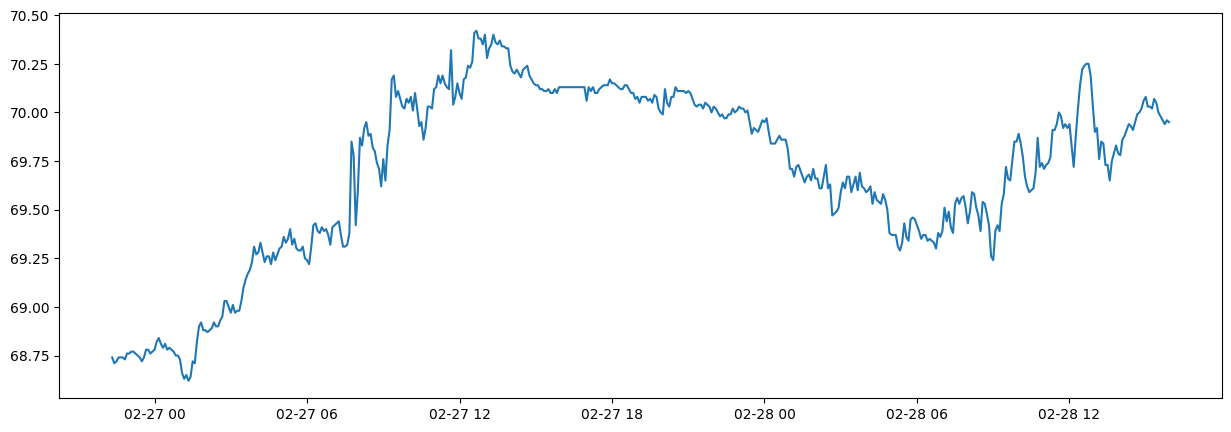

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load and preprocess
df = pd.read_csv('ALL_imputed.csv')
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')
df.fillna(method='ffill', inplace=True)

# 2. Add cyclical time features
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['DayOfWeek'] = df['Time'].dt.dayofweek
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# 3. Preprocess price features
feature_columns = ['Open_WTI', 'High_WTI', 'Low_WTI', 'Last_WTI', 'Change_WTI', '%Chg_WTI', 'Volume_WTI',
                   'Open_BRENT', 'High_BRENT', 'Low_BRENT', 'Last_BRENT', 'Change_BRENT', '%Chg_BRENT', 'Volume_BRENT',
                   'Open_GAS', 'High_GAS', 'Low_GAS', 'Last_GAS', 'Change_GAS', '%Chg_GAS', 'Volume_GAS']

def convert_percentage_to_float(value):
    if isinstance(value, str) and '%' in value:
        return float(value.replace('%', '')) / 100
    return value

for col in feature_columns:
    df[col] = df[col].apply(convert_percentage_to_float)

df[feature_columns] = df[feature_columns].astype(float)

# 4. Scale and PCA
price_scaler = MinMaxScaler()
price_scaled = price_scaler.fit_transform(df[feature_columns])

n_factors = 5
pca = PCA(n_components=n_factors)
factors = pca.fit_transform(price_scaled)

time_features = df[['Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos', 'DayOfWeek_sin', 'DayOfWeek_cos']].values
combined_features = np.hstack((factors, time_features))

# 5. Targets
target_columns = ['Last_WTI', 'Last_BRENT', 'Last_GAS']
targets = df[target_columns].values
target_scaler = MinMaxScaler()
targets_scaled = target_scaler.fit_transform(targets)

# 6. Create sliding windows
def create_sequences(features, targets, times, window_size):
    X, y, y_times = [], [], []
    for i in range(window_size, len(features)):
        X.append(features[i - window_size:i])
        y.append(targets[i])
        y_times.append(times[i])
    return np.array(X), np.array(y), np.array(y_times)

window_size = 24  # 2 hours history
X, y, y_times = create_sequences(combined_features, targets_scaled, df['Time'].values, window_size)

# 7. Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
y_times_test = y_times[split:]

# 8. Build LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(window_size, X.shape[2])))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.3))
model.add(Dense(3))  # 3 targets
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# 9. Train LSTM with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping], verbose=1)

# 10. Predict
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_actual = target_scaler.inverse_transform(y_test)

# 11. Evaluate
results_df = pd.DataFrame({
    'Time': y_times_test,
    'Actual_WTI': y_test_actual[:, 0],
    'Predicted_WTI': y_pred[:, 0],
    'Actual_BRENT': y_test_actual[:, 1],
    'Predicted_BRENT': y_pred[:, 1],
    'Actual_GAS': y_test_actual[:, 2],
    'Predicted_GAS': y_pred[:, 2]
})

for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    mae = mean_absolute_error(y_test_actual[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred[:, i]))
    print(f'{name} - LSTM MAE: {mae:.4f}, RMSE: {rmse:.4f}')

# 13. Plot
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    plt.figure(figsize=(15, 5))
    plt.plot(results_df['Time'][-500:], results_df[f'Actual_{name}'][-500:], label='Actual')
    plt.plot(results_df['Time'][-500:], results_df[f'FAVAR_{name}'][-500:], label='FAVAR', linestyle='--')
    plt.plot(results_df['Time'][-500:], results_df[f'LSTM_{name}'][-500:], label='LSTM', linestyle=':')
    plt.title(f'{name} Price Prediction (Last 500 points)')
    plt.xlabel('Datetime')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{name}_comparison_favar_lstm.png')
    plt.close()


KeyError: 'Predicted_FAVAR_WTI'

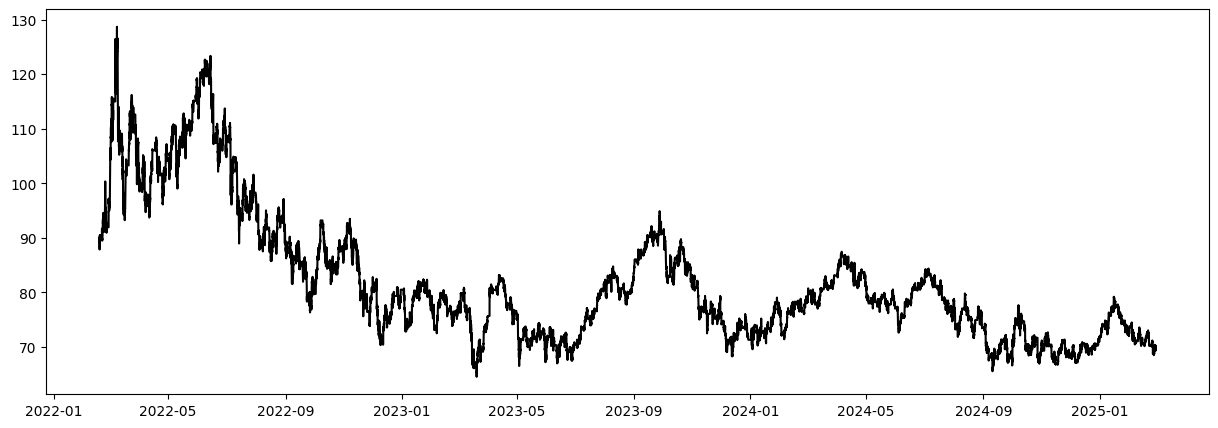

In [ ]:
# Full Code: FAVAR + Bidirectional LSTM (improved)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam

# 1. Load and prepare the data
df = pd.read_csv('ALL_imputed.csv')
# df = df.iloc[-100000:]  # Optionally select last 100,000 data if needed

df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')
df.fillna(method='ffill', inplace=True)

# 2. Time-based cyclical features
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['DayOfWeek'] = df['Time'].dt.dayofweek
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# 3. Price feature preparation
feature_columns = ['Open_WTI', 'High_WTI', 'Low_WTI', 'Last_WTI', 'Change_WTI', '%Chg_WTI', 'Volume_WTI',
                   'Open_BRENT', 'High_BRENT', 'Low_BRENT', 'Last_BRENT', 'Change_BRENT', '%Chg_BRENT', 'Volume_BRENT',
                   'Open_GAS', 'High_GAS', 'Low_GAS', 'Last_GAS', 'Change_GAS', '%Chg_GAS', 'Volume_GAS']

def convert_percentage_to_float(value):
    if isinstance(value, str) and '%' in value:
        return float(value.replace('%', '')) / 100
    return value

for col in feature_columns:
    df[col] = df[col].apply(convert_percentage_to_float)

df[feature_columns] = df[feature_columns].astype(float)

# 4. Scale and extract PCA factors
price_scaler = MinMaxScaler()
price_scaled = price_scaler.fit_transform(df[feature_columns])

n_factors = 5
pca = PCA(n_components=n_factors)
factors = pca.fit_transform(price_scaled)

# 5. Combine with time features
time_features = df[['Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos', 'DayOfWeek_sin', 'DayOfWeek_cos']].values
combined_features = np.hstack((factors, time_features))

# 6. Prepare targets
target_columns = ['Last_WTI', 'Last_BRENT', 'Last_GAS']
targets = df[target_columns].values
target_scaler = MinMaxScaler()
targets_scaled = target_scaler.fit_transform(targets)

# 7. Sliding window function
def create_sequences(features, targets, times, window_size):
    X_flat, X_seq, y, y_times = [], [], [], []
    for i in range(window_size, len(features)):
        X_seq.append(features[i - window_size:i])                    # For LSTM
        X_flat.append(features[i - window_size:i].flatten())         # For FAVAR
        y.append(targets[i])
        y_times.append(times[i])
    return np.array(X_flat), np.array(X_seq), np.array(y), np.array(y_times)

window_size = 12
X_flat, X_seq, y, y_times = create_sequences(combined_features, targets_scaled, df['Time'].values, window_size)

# 8. Train-test split
split = int(0.8 * len(X_flat))
X_flat_train, X_flat_test = X_flat[:split], X_flat[split:]
X_seq_train, X_seq_test = X_seq[:split], X_seq[split:]
y_train, y_test = y[:split], y[split:]
y_times_test = y_times[split:]

# 9. FAVAR (Linear Regression)
favar_model = LinearRegression()
favar_model.fit(X_flat_train, y_train)
y_pred_favar_scaled = favar_model.predict(X_flat_test)
y_pred_favar = target_scaler.inverse_transform(y_pred_favar_scaled)

# 10. Bidirectional LSTM model
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(units=64, return_sequences=True, activation='relu'), input_shape=(window_size, X_seq.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(Bidirectional(LSTM(units=32, activation='relu')))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(3))  # WTI, BRENT, GAS outputs

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = lstm_model.fit(X_seq_train, y_train, epochs=10, batch_size=64,
                         validation_data=(X_seq_test, y_test), verbose=1)

# 11. Predictions
y_pred_lstm_scaled = lstm_model.predict(X_seq_test)
y_pred_lstm = target_scaler.inverse_transform(y_pred_lstm_scaled)
y_test_actual = target_scaler.inverse_transform(y_test)

# 12. Results DataFrame
results_df = pd.DataFrame({
    'Time': y_times_test,
    'Actual_WTI': y_test_actual[:, 0],
    'FAVAR_WTI': y_pred_favar[:, 0],
    'LSTM_WTI': y_pred_lstm[:, 0],
    'Actual_BRENT': y_test_actual[:, 1],
    'FAVAR_BRENT': y_pred_favar[:, 1],
    'LSTM_BRENT': y_pred_lstm[:, 1],
    'Actual_GAS': y_test_actual[:, 2],
    'FAVAR_GAS': y_pred_favar[:, 2],
    'LSTM_GAS': y_pred_lstm[:, 2],
})

# 13. Evaluation
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    favar_mae = mean_absolute_error(y_test_actual[:, i], y_pred_favar[:, i])
    favar_rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred_favar[:, i]))
    lstm_mae = mean_absolute_error(y_test_actual[:, i], y_pred_lstm[:, i])
    lstm_rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred_lstm[:, i]))
    print(f"{name} - FAVAR MAE: {favar_mae:.4f}, RMSE: {favar_rmse:.4f} | LSTM MAE: {lstm_mae:.4f}, RMSE: {lstm_rmse:.4f}")

# 14. Plot
for i, name in enumerate(['WTI', 'BRENT', 'GAS']):
    plt.figure(figsize=(15, 5))
    plt.plot(results_df['Time'], results_df[f'Actual_{name}'], label='Actual')
    plt.plot(results_df['Time'], results_df[f'FAVAR_{name}'], label='FAVAR', linestyle='--')
    plt.plot(results_df['Time'], results_df[f'LSTM_{name}'], label='LSTM', linestyle=':')
    plt.title(f'{name} Price Prediction (All Test Data)')
    plt.xlabel('Datetime')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{name}_comparison_favar_bidirectional_lstm.png')
    plt.close()
